In [1]:
import re
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import json
plt.style.use("seaborn")

### Data Cleaning

In [3]:
import pandas as pd
df = pd.read_json("data.json")

In [9]:
import mysql.connector

try:
    db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='zyq990717@',
    database='public_health_new')

    db_cursor = db.cursor()
    sql = '''select * from tweets_distinct''';
    db_cursor.execute(sql);
    results = db_cursor.fetchall()
finally:
    db_cursor.close()
    db.close()
    
df = pd.DataFrame(results,columns=["url","date","content","tweet_id","replyCount","retweetCount","likeCount","quoteCount","quotedId","inReplyToTweetId",
    "conversationId","place"])

In [7]:
df = df[(df["date"] >= "2018-09-01")&(df["date"] < "2020-02-01")]

In [8]:
df

,url,date,content,tweet_id,replyCount,retweetCount,likeCount,quoteCount,quotedId,inReplyToTweetId,...,place,COVID,YYYY-MM,pos,neg,neu,compound,sentiment_label,tokenized_words,lemmatized_sentence
474161,https://twitter.com/RubyMcrae/status/122339454...,2020-01-31 23:01:04,That sucks. I quit smoking and ate like a sta...,1223394548426080256,1,0,1,0,NaN,1.223394e+18,...,None,False,2020-01,0.292,0.245,0.463,0.2500,pos,"[suck, quit, smoke, ate, like, starve, bear, h...",suck quit smoke ate like starve bear hibernati...
474162,https://twitter.com/fxckniko/status/1223394053...,2020-01-31 23:01:06,i do have to pretend to quit smoking every sin...,1223394053347250176,0,1,9,0,NaN,NaN,...,None,False,2020-01,0.127,0.052,0.821,0.4588,pos,"[pretend, quit, smoke, every_single, day, make...",pretend quit smoke every_single day make cigar...
474163,https://twitter.com/nikco56/status/12233926862...,2020-01-31 23:01:40,Why would Iyou think that taking flavor vapes...,1223392686213746688,0,0,0,0,NaN,NaN,...,None,False,2020-01,0.093,0.099,0.808,-0.0772,neg,"[iyou, think, take, flavor, vapes, away, stop,...",iyou think take flavor vapes away stop age smo...
474164,https://twitter.com/chloe_malpus/status/122339...,2020-01-31 23:01:13,Decided to quit smoking just in time for the n...,1223392070947278848,0,0,0,0,NaN,NaN,...,None,False,2020-01,0.163,0.000,0.837,0.5106,pos,"[decide, quit, smoking, time, new_year, januar...",decide quit smoking time new_year january free...
474165,https://twitter.com/TrotterKingston/status/122...,2020-01-31 23:01:24,I can attest to that. Quit smoking six years a...,1223390858273284096,0,0,1,0,1.222929e+18,NaN,...,None,False,2020-01,0.287,0.000,0.713,0.9333,pos,"[can_attest, quit, smoking, six_years, ago, ye...",can_attest quit smoking six_years ago years_ol...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2531611,https://twitter.com/prodbymaaliw/status/103569...,2018-09-01 00:09:49,"smoking cessation attempt #1209312038785426, d...",1035690656507691008,0,0,0,0,NaN,NaN,...,None,False,2018-09,0.000,0.000,1.000,0.0000,neu,"[smoke, cessation, attempt, day]",smoke cessation attempt day
2531612,https://twitter.com/StrainSpot/status/10356903...,2018-09-01 00:09:28,Bubble Gum #CannabisCommunity #MMJ #Marijuana...,1035690315582238720,0,1,0,0,NaN,NaN,...,None,False,2018-09,0.000,0.000,1.000,0.0000,neu,"[bubble_gum, cannabiscommunity_mmj, marijuana,...",bubble_gum cannabiscommunity_mmj marijuana weed
2531613,https://twitter.com/catsohaze/status/103568939...,2018-09-01 00:09:47,Gum is like my cigarettes,1035689390574428160,0,0,0,0,NaN,NaN,...,None,False,2018-09,0.385,0.000,0.615,0.3612,pos,"[gum, like, cigarette]",gum like cigarette
2531614,https://twitter.com/arturm4u6o/status/10356846...,2018-09-01 00:09:56,Smoking Cessation Counseling -,1035684648620371968,0,0,0,0,NaN,NaN,...,None,False,2018-09,0.000,0.000,1.000,0.0000,neu,"[smoke, cessation_counseling]",smoke cessation_counseling


In [41]:
import re
def removeEmail(item):
    if "@" in item:
        new_item = re.sub(r'\w+@\w+([\.]+\w+)+','',item)
    else:
        new_item = item
    return new_item

def removeURL(item):
    if re.search(r'\.[a-z]+',item) or re.search("http",item):
        new_item = re.sub(r"((https?):\/+)?(www.)?[a-zA-Z0-9\-]+(\.[a-z]+)+(\/[a-zA-Z0-9#]+\??((\.[a-z]+)|((&?[a-zA-Z0-9]+\=[a-zA-Z0-9]+)*))*)*\/?",'',item)
        new_item = re.sub(r"\(?https?:\/+[\w \.:/]*\)?",'',new_item)
    else:
        new_item = item
    return new_item

def removeUserName(txt):
    return re.sub(r"@\w+","",txt)

def cleanText(txt):
    """
        remove email, username, and url within tweets
    """
    tmp = removeEmail(txt)
    tmp = removeUserName(tmp)
    new_txt = removeURL(tmp)
    return new_txt

In [42]:
df["content"] = df["content"].apply(cleanText)

### Temporal and Sentiment Analysis

In [43]:
df["YYYY-MM"] = df["date"].apply(lambda x:x.strftime("%Y-%m"))

In [44]:
mon_count = df.groupby("YYYY-MM").count()["tweet_id"]

In [45]:
search_keywords = [r"quit smoking",r"quitting smoking",r"quitted smoking",r"quits smoking",r"stop smoking",r"stopping smoking",
                   r"stopped smoking",r"stops smoking",r"quit cigarettes",r"quitting cigarettes",r"quitted cigarettes",r"quits cigarettes",
                   r"stop cigarettes",r"stopping cigarettes",r"stopped cigarettes",r"stops cigarettes",r"smoke less", r"smoking less",
                   r"smoked less",r"smokes less",r"\bnrt\b", r"\bpatch\b", r"\blozenge\b",r"\bspray\b", r"\bgum\b", r"\bnicorette\b", 
                   r"\bcessation\b",r"#quit\b",r"#quitsmoking\b",r"#quitsmokingcigarettes\b", r"#Cessationnation\b"]

pattern = re.compile("|".join(search_keywords))

df["controlled_content"] = df["content"].apply(lambda x:pattern.sub("X",x))

In [48]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
analyzer = SentimentIntensityAnalyzer()

controlled_texts = df["controlled_content"]

controlled_texts = controlled_texts.astype(str)
controlled_sentiments = controlled_texts.apply(analyzer.polarity_scores)


In [49]:
df["controlled_compound"] = controlled_sentiments.apply(lambda x:x["compound"])
df["controlled_sentiment_label"] = df["controlled_compound"].apply(lambda x: "pos" if x >= 0.05 else "neg" if x<= -0.05 else "neu")

In [51]:
controlled_mon_sentiment = df.groupby("YYYY-MM").mean(numeric_only=True)["controlled_compound"]

/var/folders/fx/94vx28g17c9172vwjsxbmsk80000gn/T/ipykernel_93372/2220034152.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(controlled_mon_sentiment.index,rotation=45)


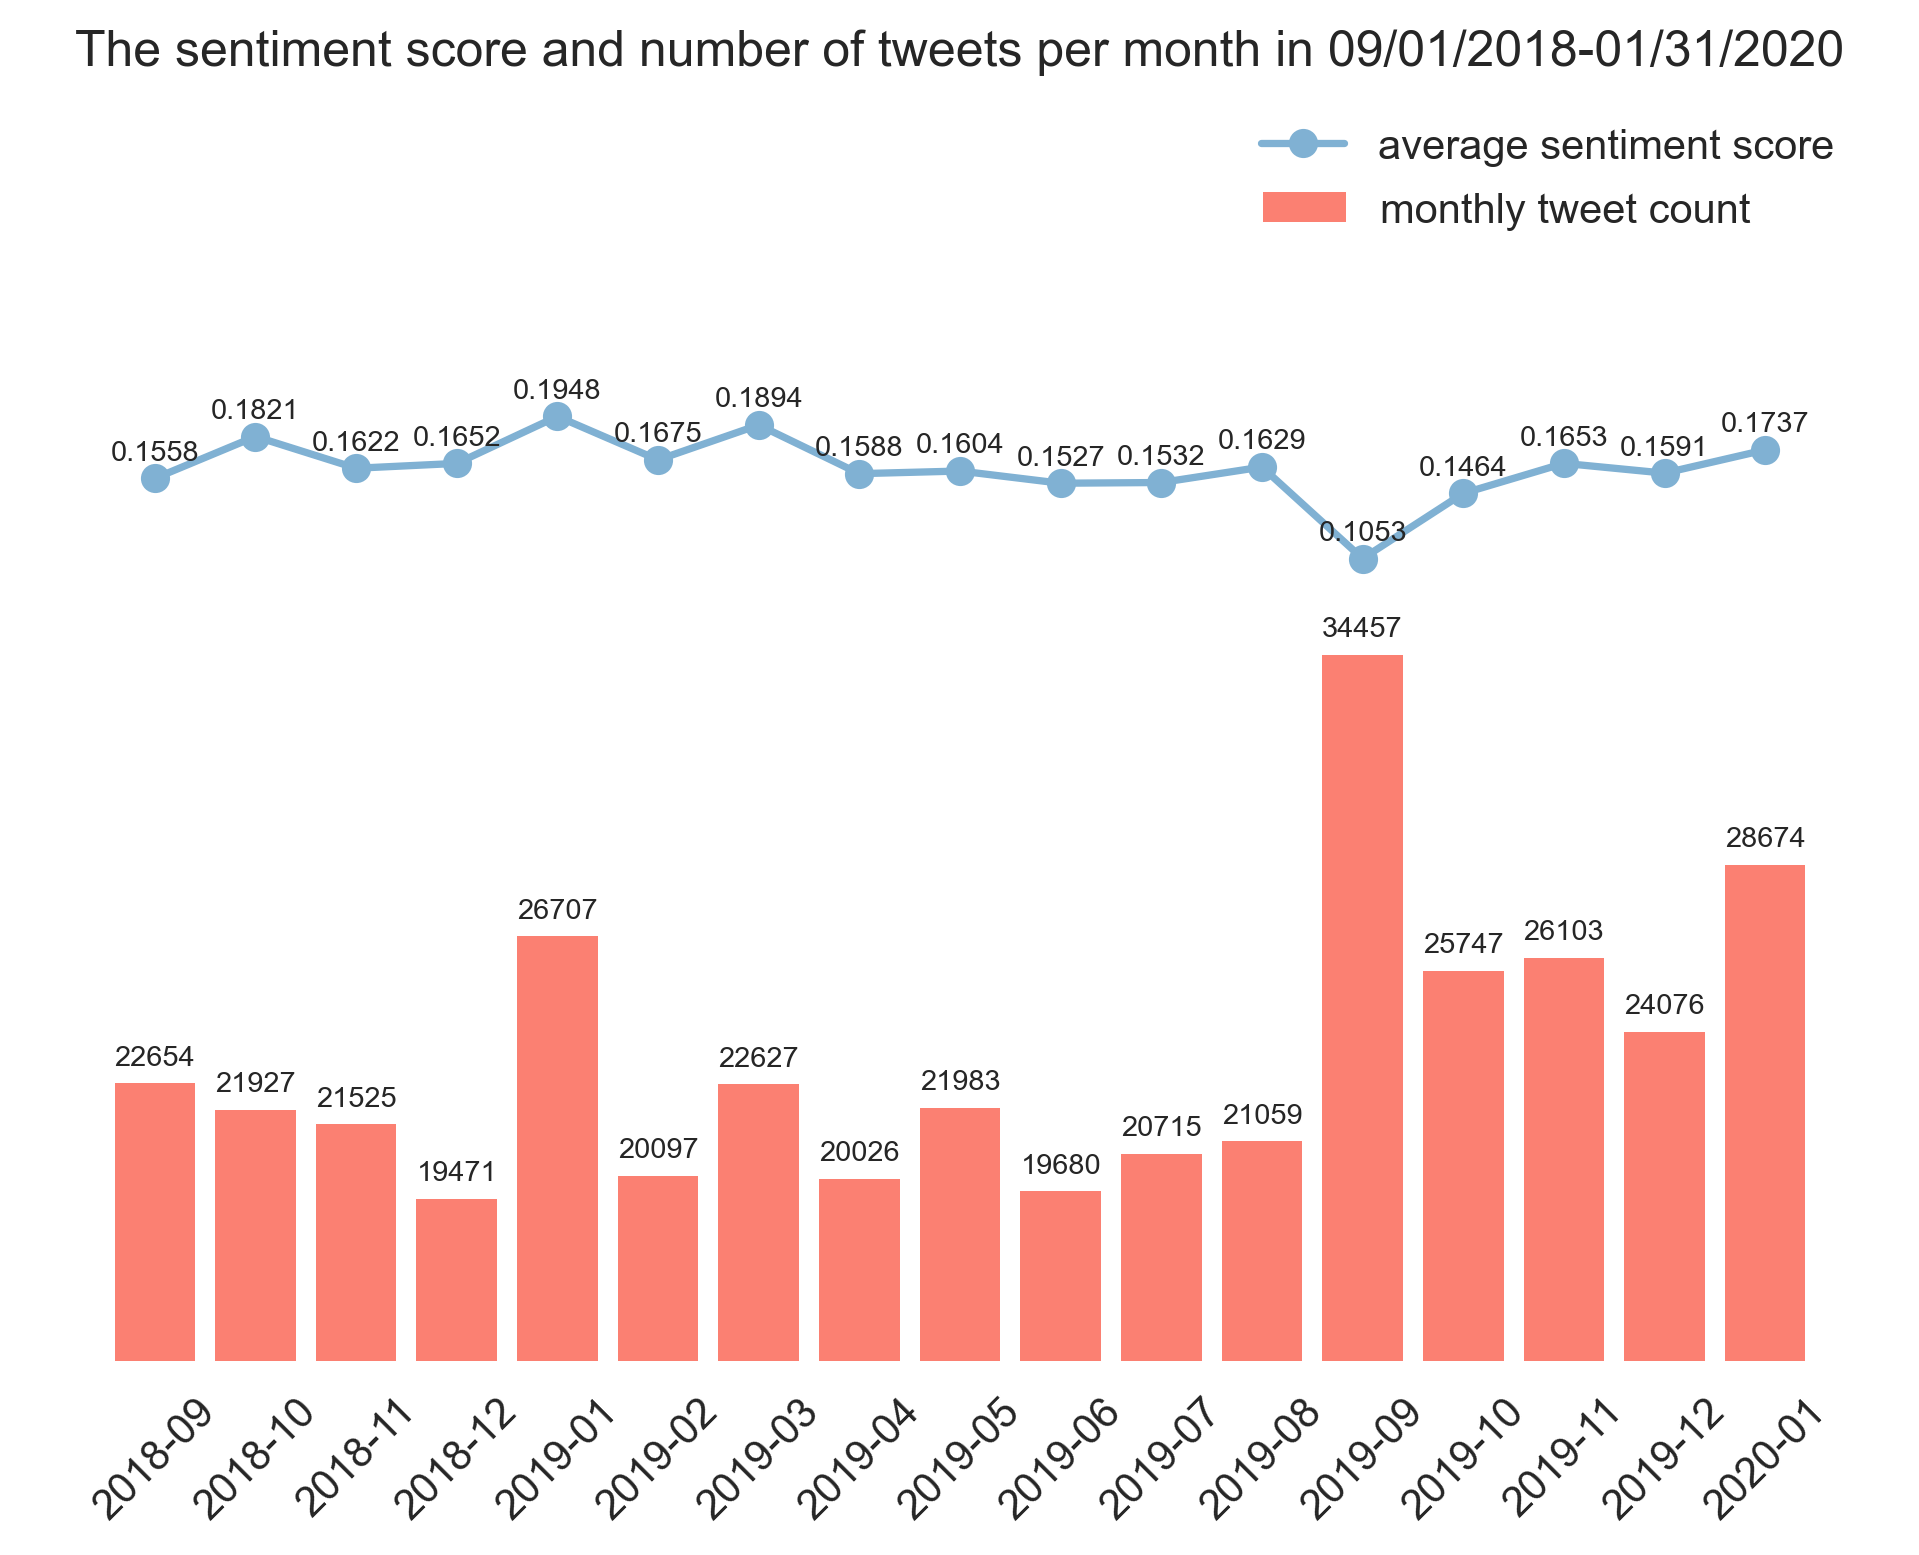

In [122]:
fig, ax = plt.subplots(dpi=300)
bars = ax.bar(mon_count.index,mon_count,label="monthly tweet count",color=sns.color_palette("Set3")[3])
for b in bars:
   height = b.get_height()
   ax.annotate('{}'.format(height),
      xy=(b.get_x() + b.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      fontsize='x-small',
      ha='center', va='bottom')
ax.set_ylim(15000,50000)
ax.set_yticklabels([])
ax.set_xticklabels(controlled_mon_sentiment.index,rotation=45)
ax.grid(visible=None)
ax.set_facecolor('none')  # for the axis
ax.legend(bbox_to_anchor=(0.945, 0.95))

ax2 = ax.twinx()
lines = ax2.plot(controlled_mon_sentiment.index,controlled_mon_sentiment,linestyle="-",marker="o",label="average sentiment score",color=sns.color_palette("Set3")[4])
for i,b in enumerate(controlled_mon_sentiment):
   height = b
   ax2.annotate(text='{}'.format(np.round(b,4)),
      xy=(i,height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      fontsize='x-small',
      ha='center', va='bottom')
ax2.set_ylim(-0.4,0.4)
ax2.set_yticklabels([])
ax2.grid(visible=None)
ax2.set_facecolor('none')  # for the axis
plt.title("The sentiment score and number of tweets per month in 09/01/2018-01/31/2020")
ax2.legend(bbox_to_anchor=(0.99, 1))
fig.set_facecolor('none') # for the figure
fig.savefig('figure1.jpg', format='jpeg', dpi=300, transparent=False)
plt.show()

/var/folders/fx/94vx28g17c9172vwjsxbmsk80000gn/T/ipykernel_93372/55303574.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(controlled_mon_sentiment.index, rotation=45)


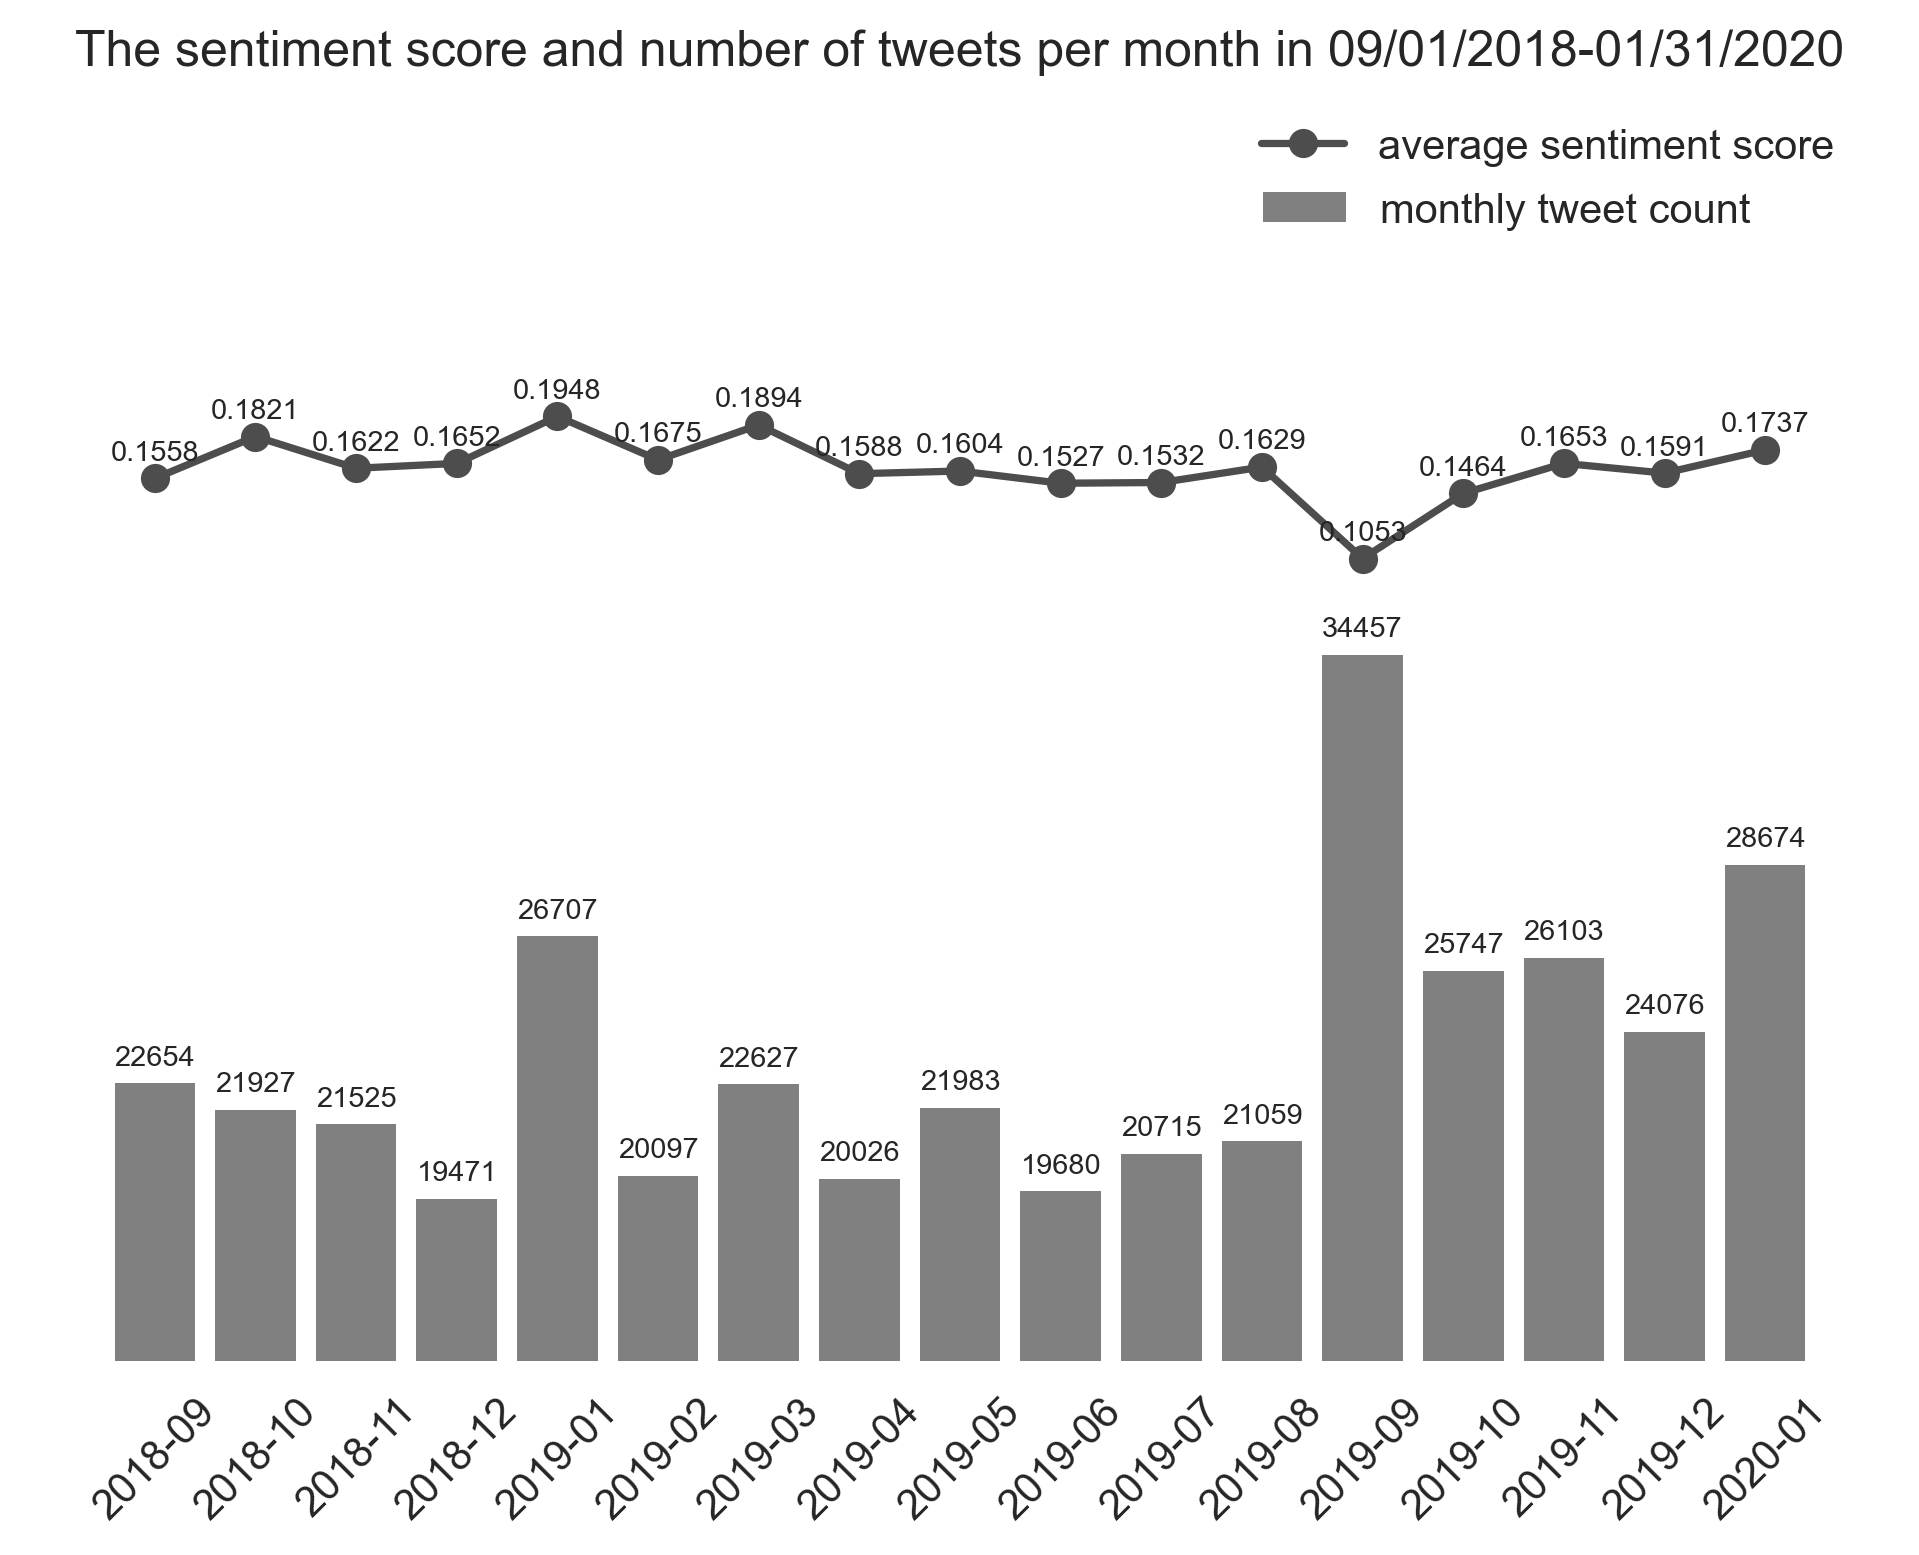

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you have mon_count and controlled_mon_sentiment loaded...

fig, ax = plt.subplots(dpi=300)

# Using a shade of gray for the bars
bars = ax.bar(mon_count.index, mon_count, label="monthly tweet count", color='0.5')
for b in bars:
    height = b.get_height()
    ax.annotate('{}'.format(height),
                xy=(b.get_x() + b.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                fontsize='x-small',
                ha='center', va='bottom')
ax.set_ylim(15000, 50000)
ax.set_yticklabels([])
ax.set_xticklabels(controlled_mon_sentiment.index, rotation=45)
ax.grid(visible=None)
ax.set_facecolor('none')  # for the axis
ax.legend(bbox_to_anchor=(0.945, 0.95))

ax2 = ax.twinx()

# Using a darker shade of gray for the line plot
lines = ax2.plot(controlled_mon_sentiment.index, controlled_mon_sentiment, linestyle="-", marker="o", label="average sentiment score", color='0.3')
for i, b in enumerate(controlled_mon_sentiment):
    height = b
    ax2.annotate(text='{}'.format(np.round(b, 4)),
                 xy=(i, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 fontsize='x-small',
                 ha='center', va='bottom')
ax2.set_ylim(-0.4, 0.4)
ax2.set_yticklabels([])
ax2.grid(visible=None)
ax2.set_facecolor('none')  # for the axis
plt.title("The sentiment score and number of tweets per month in 09/01/2018-01/31/2020")
ax2.legend(bbox_to_anchor=(0.99, 1))
fig.set_facecolor('none')  # for the figure
fig.savefig('Mono figure1.jpg', format='jpeg', dpi=300, transparent=False)
plt.show()


In [29]:
controlled_mon_pos_sentiment = df[df["controlled_sentiment_label"]=="pos"].groupby("YYYY-MM").mean()["controlled_compound"]
controlled_mon_neg_sentiment = df[df["controlled_sentiment_label"]=="neg"].groupby("YYYY-MM").mean()["controlled_compound"]
controlled_mon_neu_sentiment = df[df["controlled_sentiment_label"]=="neu"].groupby("YYYY-MM").mean()["controlled_compound"]

/var/folders/fx/94vx28g17c9172vwjsxbmsk80000gn/T/ipykernel_93372/1416843016.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  controlled_mon_pos_sentiment = df[df["controlled_sentiment_label"]=="pos"].groupby("YYYY-MM").mean()["controlled_compound"]
/var/folders/fx/94vx28g17c9172vwjsxbmsk80000gn/T/ipykernel_93372/1416843016.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  controlled_mon_neg_sentiment = df[df["controlled_sentiment_label"]=="neg"].groupby("YYYY-MM").mean()["controlled_compound"]
/var/folders/fx/94vx28g17c9172vwjsxbmsk80000gn/T/ipykernel_93372/1416843016.py:3: FutureWarning: The default v

In [30]:
controlled_mon_pos = df[df["controlled_sentiment_label"]=="pos"].groupby("YYYY-MM").count()["tweet_id"]
controlled_mon_neg = df[df["controlled_sentiment_label"]=="neg"].groupby("YYYY-MM").count()["tweet_id"]
controlled_mon_neu = df[df["controlled_sentiment_label"]=="neu"].groupby("YYYY-MM").count()["tweet_id"]

In [31]:
controlled_mon_pos_pctg = controlled_mon_pos / mon_count
controlled_mon_neg_pctg = controlled_mon_neg / mon_count
controlled_mon_neu_pctg = controlled_mon_neu / mon_count

/var/folders/fx/94vx28g17c9172vwjsxbmsk80000gn/T/ipykernel_93372/1495799568.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(controlled_mon_pos_sentiment.index,rotation=45)
/var/folders/fx/94vx28g17c9172vwjsxbmsk80000gn/T/ipykernel_93372/1495799568.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(controlled_mon_pos_pctg.index,rotation=45)
/var/folders/fx/94vx28g17c9172vwjsxbmsk80000gn/T/ipykernel_93372/1495799568.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


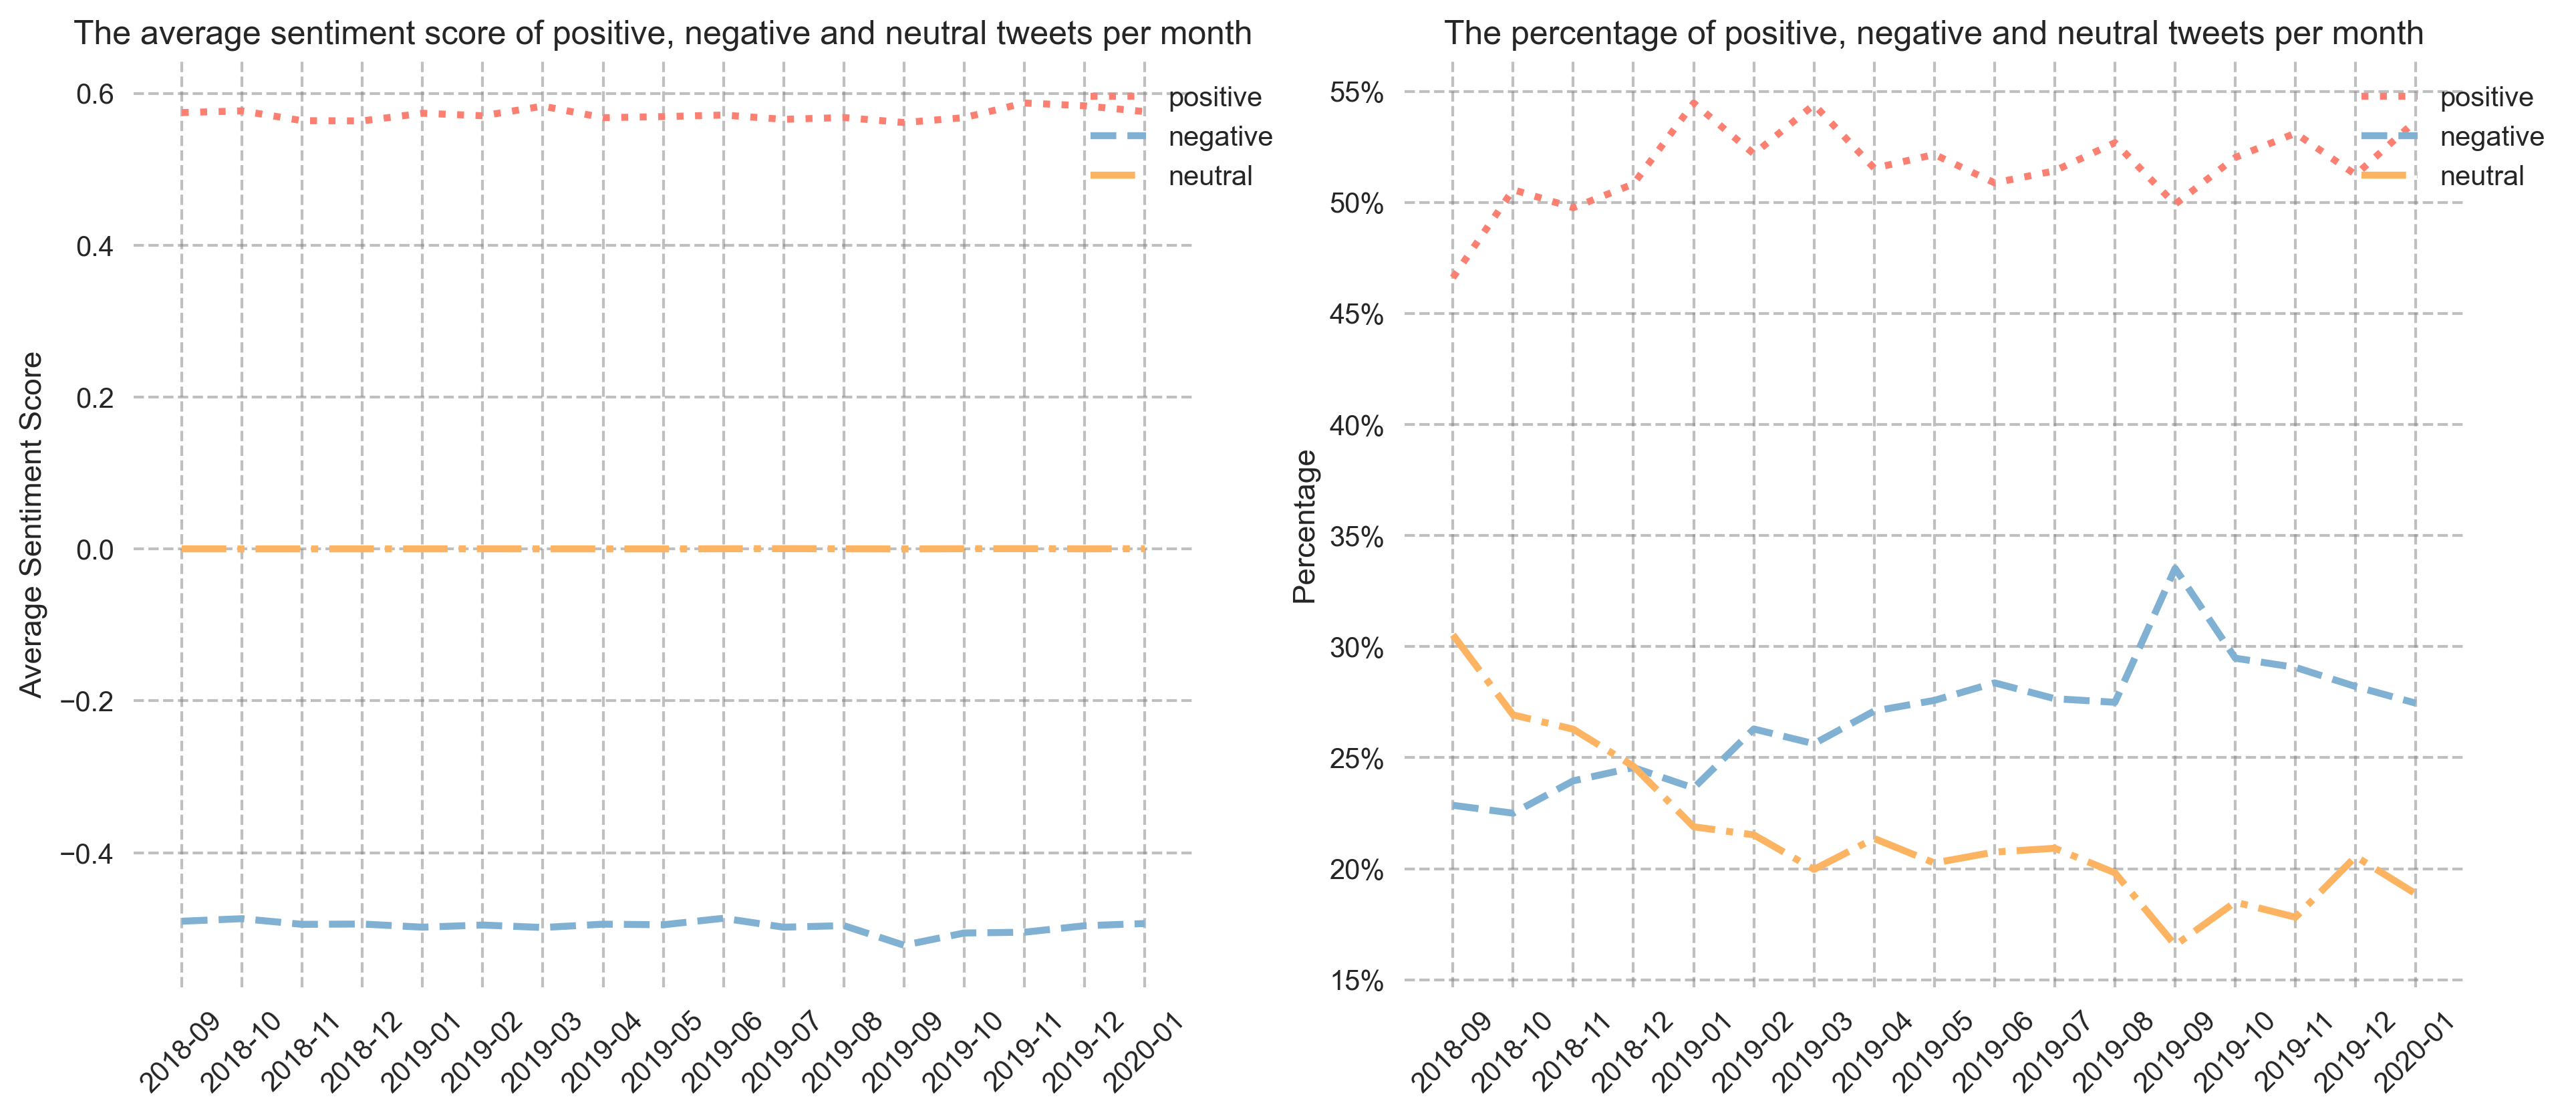

In [124]:
fig, [ax1,ax2] = plt.subplots(nrows=1, ncols=2, figsize=(15,6),dpi=300)
ax1.plot(controlled_mon_pos_sentiment.index,controlled_mon_pos_sentiment,label="positive",color=sns.color_palette("Set3")[3],linestyle="dotted",linewidth=2.5)
ax1.plot(controlled_mon_neg_sentiment.index,controlled_mon_neg_sentiment,label="negative",color=sns.color_palette("Set3")[4],linestyle="dashed",linewidth=2.5)
ax1.plot(controlled_mon_neu_sentiment.index,controlled_mon_neu_sentiment,label="neutral",color=sns.color_palette("Set3")[5],linestyle="dashdot",linewidth=2.5)
ax1.set_facecolor("none")
#set y axis grid according to the range of y axis
ax1.grid(True,which='major',axis='y',color='gray',alpha=0.5,linestyle='--')
ax1.grid(True,which='major',axis='x',color='gray',alpha=0.5,linestyle='--')
ax1.set_xticklabels(controlled_mon_pos_sentiment.index,rotation=45)

ax1.set_ylabel("Average Sentiment Score")
ax1.set_title("The average sentiment score of positive, negative and neutral tweets per month")
ax1.legend(loc='upper right', bbox_to_anchor=(1.1, 1),fancybox=True, shadow=True)

ax2.plot(controlled_mon_pos_pctg.index,controlled_mon_pos_pctg,label="positive",color=sns.color_palette("Set3")[3],linestyle="dotted",linewidth=2.5)
ax2.plot(controlled_mon_neg_pctg.index,controlled_mon_neg_pctg,label="negative",color=sns.color_palette("Set3")[4],linestyle="dashed",linewidth=2.5)
ax2.plot(controlled_mon_neu_pctg.index,controlled_mon_neu_pctg,label="neutral",color=sns.color_palette("Set3")[5],linestyle="dashdot",linewidth=2.5)
# Remove background color
ax2.set_facecolor('none')  # for the axis
ax2.grid(True,which='major',axis='y',color='gray',alpha=0.5,linestyle='--')
ax2.grid(True,which='major',axis='x',color='gray',alpha=0.5,linestyle='--')
ax2.set_xticklabels(controlled_mon_pos_pctg.index,rotation=45)

ax2.set_ylabel("Percentage")
#set y axis label by percentage
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

ax2.legend(loc='upper right', bbox_to_anchor=(1.1, 1),fancybox=True, shadow=True)
ax2.set_title("The percentage of positive, negative and neutral tweets per month")

fig.set_facecolor('none') # for the figure
fig.savefig('figure2.jpg', format='jpeg', dpi=300, transparent=False)
plt.show()

/var/folders/fx/94vx28g17c9172vwjsxbmsk80000gn/T/ipykernel_93372/3558638712.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(controlled_mon_pos_sentiment.index,rotation=45)
/var/folders/fx/94vx28g17c9172vwjsxbmsk80000gn/T/ipykernel_93372/3558638712.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(controlled_mon_pos_pctg.index,rotation=45)
/var/folders/fx/94vx28g17c9172vwjsxbmsk80000gn/T/ipykernel_93372/3558638712.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


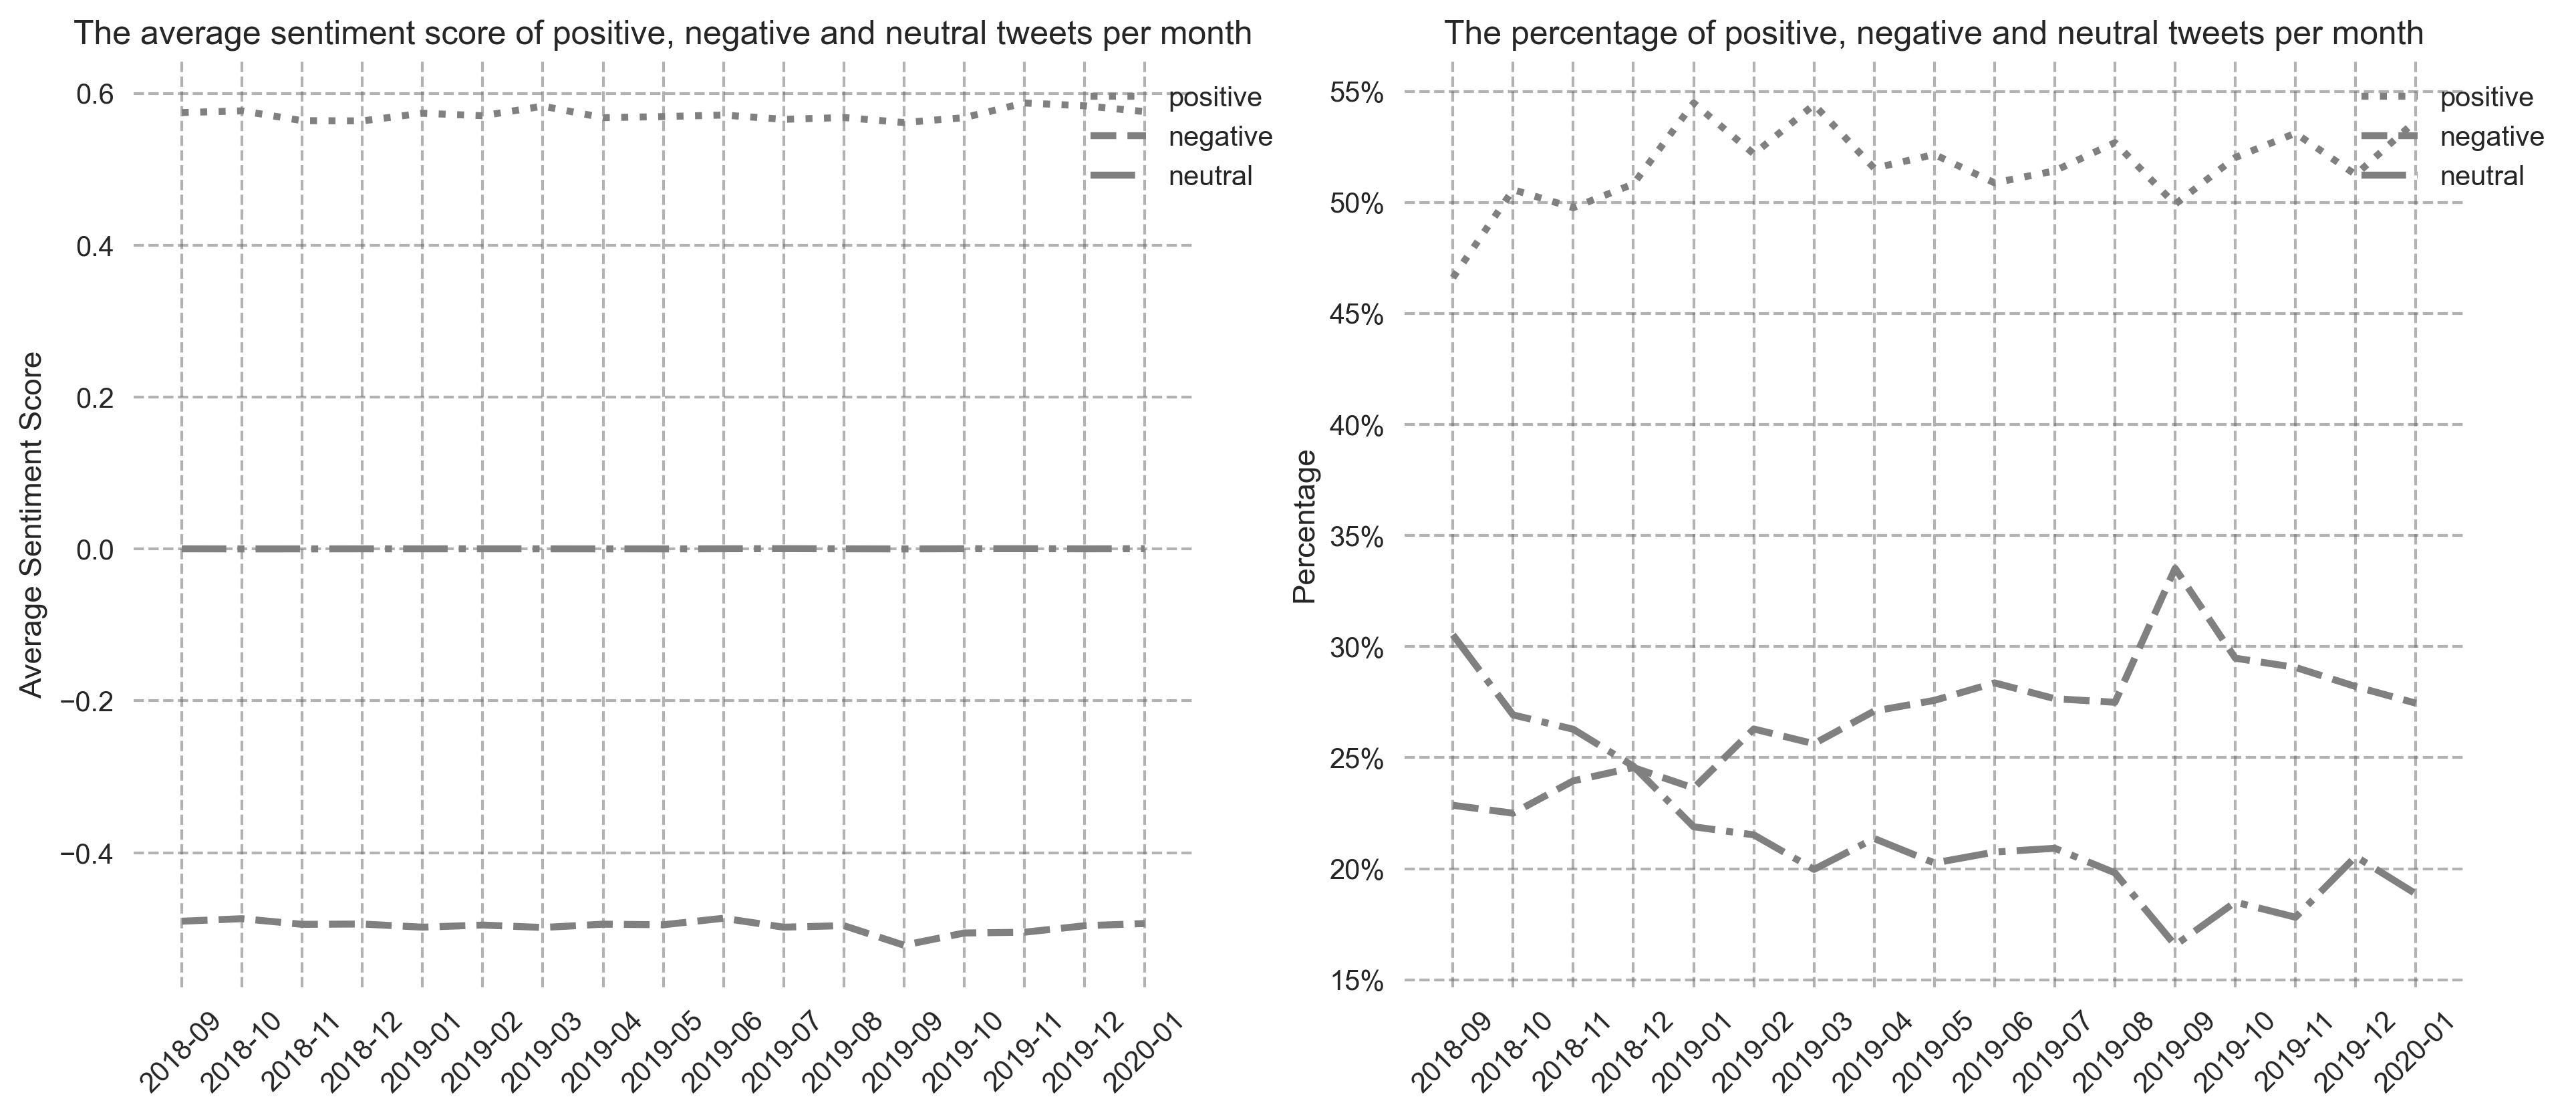

In [125]:
fig, [ax1,ax2] = plt.subplots(nrows=1, ncols=2, figsize=(15,6),dpi=300)
ax1.plot(controlled_mon_pos_sentiment.index,controlled_mon_pos_sentiment,label="positive",color='0.5',linestyle="dotted",linewidth=2.5)
ax1.plot(controlled_mon_neg_sentiment.index,controlled_mon_neg_sentiment,label="negative",color='0.5',linestyle="dashed",linewidth=2.5)
ax1.plot(controlled_mon_neu_sentiment.index,controlled_mon_neu_sentiment,label="neutral",color='0.5',linestyle="dashdot",linewidth=2.5)
ax1.set_facecolor("none")
#set y axis grid according to the range of y axis
ax1.grid(True,which='major',axis='y',color='0.4',alpha=0.5,linestyle='--')
ax1.grid(True,which='major',axis='x',color='0.4',alpha=0.5,linestyle='--')
ax1.set_xticklabels(controlled_mon_pos_sentiment.index,rotation=45)

ax1.set_ylabel("Average Sentiment Score")
ax1.set_title("The average sentiment score of positive, negative and neutral tweets per month")
ax1.legend(loc='upper right', bbox_to_anchor=(1.1, 1),fancybox=True, shadow=True)

ax2.plot(controlled_mon_pos_pctg.index,controlled_mon_pos_pctg,label="positive",color='0.5',linestyle="dotted",linewidth=2.5)
ax2.plot(controlled_mon_neg_pctg.index,controlled_mon_neg_pctg,label="negative",color='0.5',linestyle="dashed",linewidth=2.5)
ax2.plot(controlled_mon_neu_pctg.index,controlled_mon_neu_pctg,label="neutral",color='0.5',linestyle="dashdot",linewidth=2.5)
# Remove background color
ax2.set_facecolor('none')  # for the axis
ax2.grid(True,which='major',axis='y',color='0.4',alpha=0.5,linestyle='--')
ax2.grid(True,which='major',axis='x',color='0.4',alpha=0.5,linestyle='--')
ax2.set_xticklabels(controlled_mon_pos_pctg.index,rotation=45)

ax2.set_ylabel("Percentage")
#set y axis label by percentage
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

ax2.legend(loc='upper right', bbox_to_anchor=(1.1, 1),fancybox=True, shadow=True)
ax2.set_title("The percentage of positive, negative and neutral tweets per month")

fig.set_facecolor('none') # for the figure
fig.savefig('Mono figure2.jpg', format='jpeg', dpi=300, transparent=False)
plt.show()

### Latent Semantic Analysis

In [52]:
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
import spacy
import pandas as pd
from gensim.models.phrases import Phrases,ENGLISH_CONNECTOR_WORDS

all_stopwords = stopwords.words("English")
all_stopwords.extend(['would'])
sp = spacy.load('en_core_web_sm')
spacy_stopwords = sp.Defaults.stop_words
all_stopwords = list(set(all_stopwords).union(set(gensim.parsing.preprocessing.STOPWORDS)).union(set(spacy_stopwords)))
all_stopwords += list(string.punctuation)
all_stopwords += list('1234567890')

acronyms = ["shan't","mightn't","should've","hasn't","shouldn't","you'll","haven't","it's","mustn't","'re",
 "doesn't","won't","'d","don't","isn't","you'd","that'll","'s","'m","she's","n't","'ll","'ve",
 "you've","aren't","hadn't","wasn't","weren't","couldn't","didn't","you're","wouldn't","needn't"]


lemma = WordNetLemmatizer()

pattern = re.compile('['+'!"#$%&\()*+,’./:;<=>?@^_`{|}~'+'(\n)'+'“”'+'1234567890'+']')

def cleanBeforeGram(sent):
    sent = sent.replace('\\','')
    sent = str(sent).replace('\n','')
    sent = sent.lower()
    sent = pattern.sub('',sent)
    
    tokens = nltk.word_tokenize(sent)
    new_tokens = [word for word in tokens if word not in acronyms and word != "'"]
    return new_tokens

def ngramTransform(corpus:pd.Series) -> Phrases:

    bigram = Phrases(corpus,min_count=10,connector_words=ENGLISH_CONNECTOR_WORDS)
    trigram = Phrases([bigram[words] for words in corpus],min_count=10,connector_words=ENGLISH_CONNECTOR_WORDS)
    
    return trigram
    
def cleanAfterGram(words:list):
    new_tokens = [word for word in words if word not in all_stopwords]
    tags = nltk.pos_tag(new_tokens,tagset="universal")
    lemmmatized_sent = []
    get_lemma_pos = lambda tag : "n" if tag[1] == "NOUN" else "v" if tag[1] == "VERB" else "a" if tag[1] == "ADJ" else "r" if tag[1] == "ADV" else None
    for tag in tags:
        wrd = lemma.lemmatize(tag[0],pos=get_lemma_pos(tag) or 'n')  
        lemmmatized_sent.append(wrd)
    return lemmmatized_sent

def cleanContent(content:pd.Series):
    tmp = content.apply(cleanBeforeGram)
    trigram = ngramTransform(tmp)
    tmp = tmp.apply(lambda x:trigram[x])
    lemmmatized_sent = tmp.apply(cleanAfterGram)
    return lemmmatized_sent

In [53]:
df["tokenized_words"] = cleanContent(df["content"])

df['lemmatized_sentence'] = df["tokenized_words"].apply(lambda x:' '.join(x))

In [54]:
df["sentence_LSA"] = df["lemmatized_sentence"].apply(lambda x :" ".join([word for word in x.split(" ") if len(word) >= 3]))

In [55]:
# add document-specific stopwords
all_stopwords = list(set(all_stopwords + ['after_years', 'as_well', 'ago', 'away', 'baby', 'age',
                                  'bit', 'bitch', 'bro', 'call_', 'cool', 'cuz', 'damn', 'day',
                                  'didnt', 'does_make', 'doesnt', 'dont', 'dude', 'facing_this', 'feel', 'feel_like', 'fuck', 'girl',
                                  'gon_na', 'got_ta', 'guy', 'hell', 'has_been', 'help', 'hey', 'hit', 'ima', 'ive', 'ive_been', 'know','later',
                                  'least_after', 'let', 'like', 'lmao', 'lol', 'lot', 'make_yourself', 'makes_me', 'months_ago',
                                  'need', 'never_too', 'nigga', 'non', 'not_a_virgin',
                                  'okay', 'porn_premarital', 'ppl','people', 'right_now',
                                  'sex_and_extramarital', 'sexextramarital_affairto',
                                  'shit', 'sure', 'thats', 'tho', 'those_who', 'told_me','today',
                                  'try', 'tryna','think','time', 'wan_na', 'wont','want', 'way',
                                  'yall', 'yeah','youre', 'years_ago', 'year','amp']))


In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [57]:
tfidfvec  = TfidfVectorizer(lowercase=True,stop_words=all_stopwords,max_df=0.1,min_df=0.002)
tfidf_matrix = tfidfvec.fit_transform(df["sentence_LSA"])

In [58]:
from sklearn.decomposition import TruncatedSVD
lsa_obj = TruncatedSVD(n_components=10, n_iter=100, random_state=42)
tfidf_lsa_data = lsa_obj.fit_transform(tfidf_matrix)
Sigma = lsa_obj.singular_values_
V_T = lsa_obj.components_

In [59]:
document_topic_df = pd.DataFrame(tfidf_lsa_data,columns=["t{}".format(i) for i in range(1,11)])

In [60]:
df["topic"] = [num + 1 for num in np.argmax(tfidf_lsa_data,axis=1)]

In [61]:
term_topic_matrix = pd.DataFrame(V_T.T,columns=["t{}".format(i) for i in range(1,11)],index=tfidfvec.get_feature_names_out())

In [62]:
col_representing_words = [] #[num_topics,num_words]
col_representing_word_frequencies = [] #[num_topics,num_words]
for col in term_topic_matrix.columns:
    col_representing_word_frequencies.append(np.sort(term_topic_matrix[col])[::-1])
    col_representing_words.append(term_topic_matrix.index[np.argsort(term_topic_matrix[col])[::-1]])

/var/folders/fx/94vx28g17c9172vwjsxbmsk80000gn/T/ipykernel_18778/1504356958.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, ax=ax,fraction=0.046)


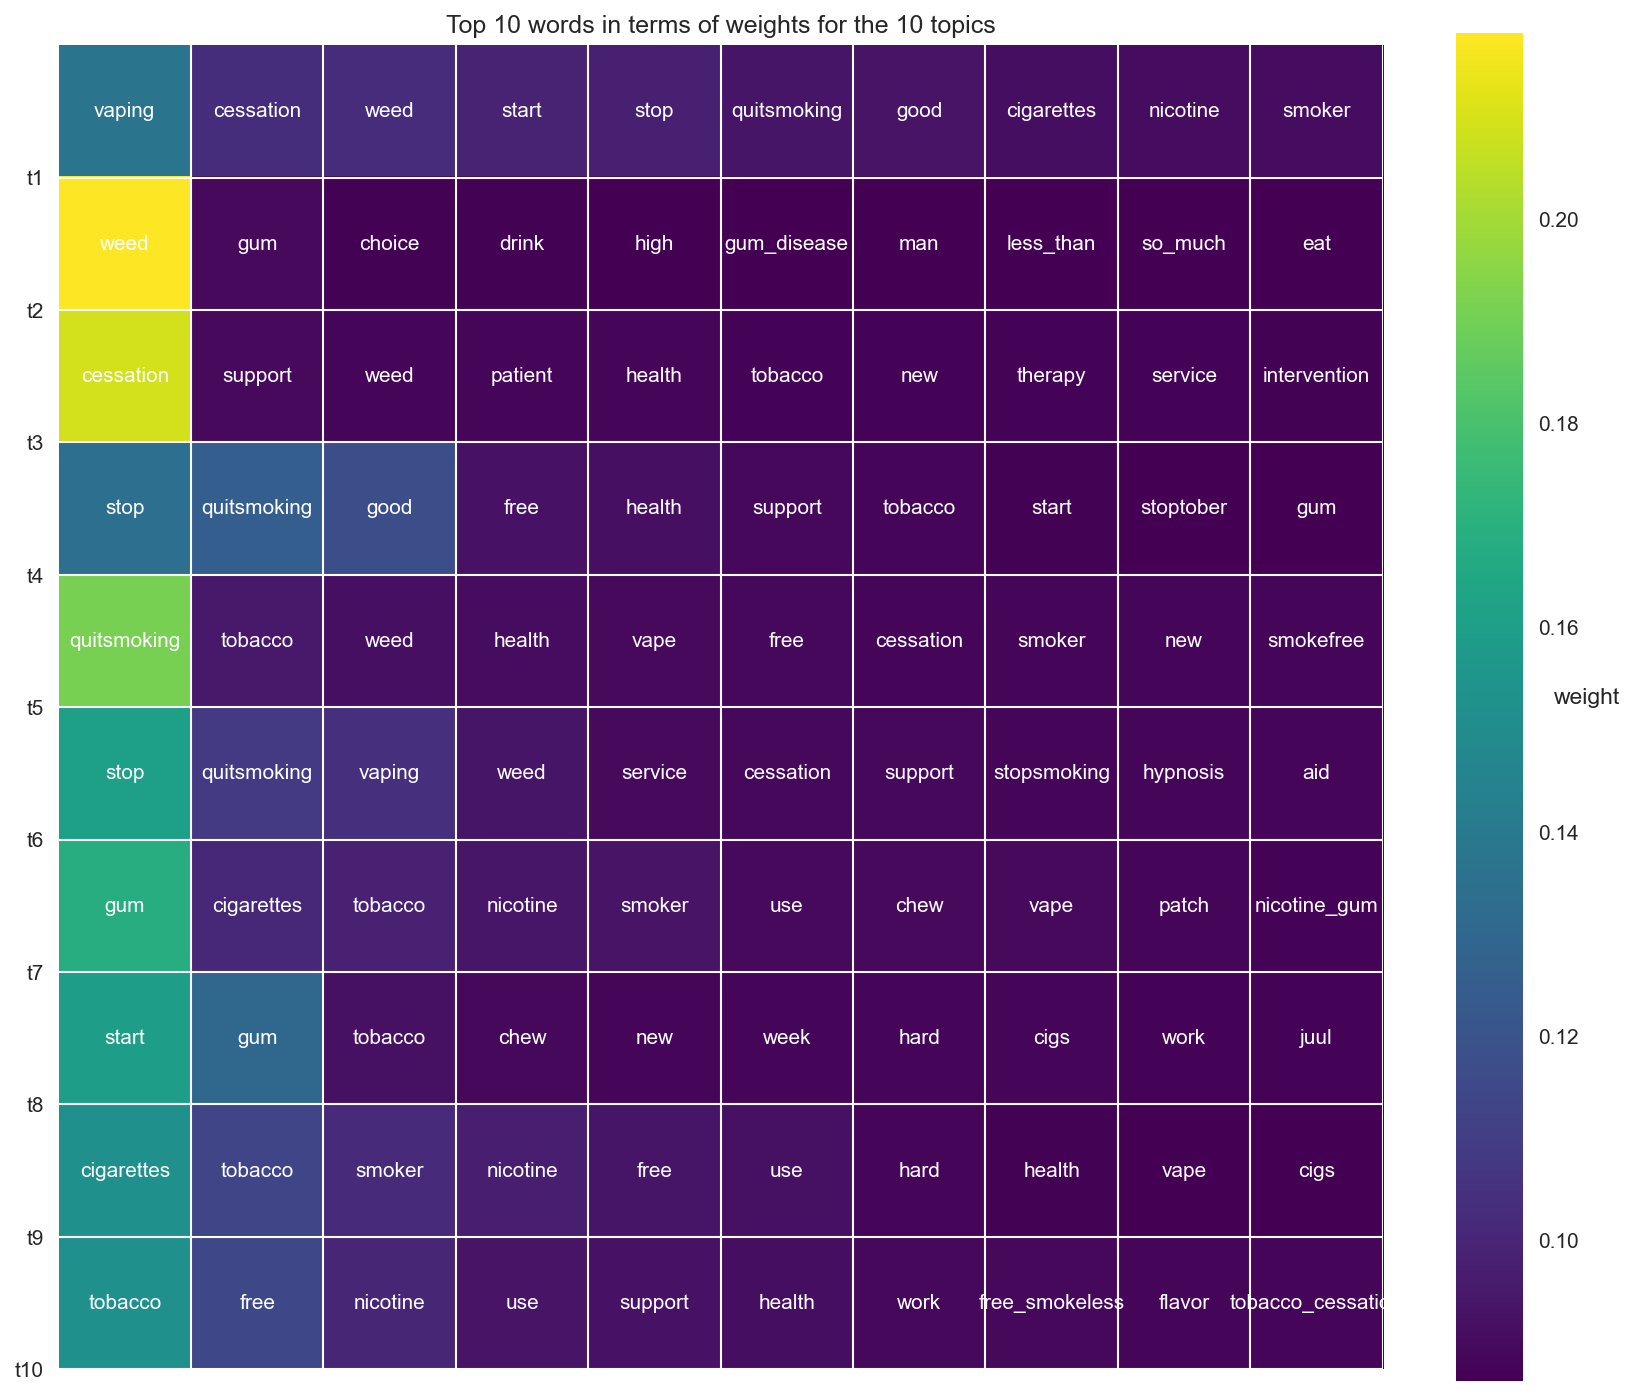

In [23]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.special import softmax

topics = ["t{}".format(i) for i in range(1,11)]

weights = np.apply_along_axis(lambda x : softmax(x), axis=1, arr=pd.DataFrame(col_representing_word_frequencies).iloc[:,0:10].to_numpy())
terms = pd.DataFrame(col_representing_words).iloc[:,0:10]

fig, ax = plt.subplots(figsize=(11,11),dpi=150)
im = ax.imshow(weights,cmap="viridis")

# Show all ticks and label them with the respective list entries
ax.set_yticks(np.arange(len(topics))+0.5, labels=topics)
ax.set_xticks(np.arange(10)+0.5)
ax.tick_params(labelbottom=False)

cbar = plt.colorbar(im, ax=ax,fraction=0.046)
cbar.ax.set_ylabel("weight", rotation=0, va="bottom")

# Loop over data dimensions and create text annotations.
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        text = ax.text(j,i, terms.iloc[i, j],
                       ha="center", va="center", color="w",wrap=False)

ax.set_title("Top 10 words in terms of weights for the 10 topics")
fig.tight_layout()

plt.show()


In [63]:
def rearrange_topic(topic):
    if topic == 1:
        return "vaping"
    elif topic == 2:
        return "cannabis"
    elif topic in [3,4,5,6]:
        return "stop smoking"
    elif topic in [7,8]:
        return "gum"
    elif topic in [9,10]:
        return "tobacco"

In [64]:
df["rearranged_topic"] = df["topic"].apply(rearrange_topic)

In [65]:
topic_vaping = pd.DataFrame({"terms":terms.loc[0,:].to_numpy().flatten(),"weights":weights[0,:].flatten()})

topic_vaping.groupby("terms").mean().reset_index(drop=False).sort_values("weights",ascending=False).iloc[0:10,]

,terms,weights
8,vaping,0.136908
0,cessation,0.103479
9,weed,0.102980
6,start,0.099429
7,stop,0.097582
4,quitsmoking,0.093631
2,good,0.093344
1,cigarettes,0.091258
3,nicotine,0.090762
5,smoker,0.090626


In [66]:
topic_cannabis = pd.DataFrame({"terms":terms.loc[1,:].to_numpy().flatten(),"weights":weights[1,:].flatten()})
topic_cannabis.groupby("terms").mean().reset_index(drop=False).sort_values("weights",ascending=False).iloc[0:10,]

,terms,weights
9,weed,0.218205
3,gum,0.089627
0,choice,0.087022
1,drink,0.086797
5,high,0.086581
4,gum_disease,0.086537
7,man,0.086439
6,less_than,0.086298
8,so_much,0.086298
2,eat,0.086195


In [67]:
topic_stop_smoking = pd.DataFrame({"terms":terms.loc[2:5,:].to_numpy().flatten(),"weights":weights[2:6,:].flatten()})

topic_stop_smoking.groupby("terms").mean().reset_index(drop=False).sort_values("weights",ascending=False).iloc[0:10,]

,terms,weights
15,stop,0.147719
10,quitsmoking,0.141677
1,cessation,0.129082
3,good,0.117935
22,vaping,0.103843
23,weed,0.091420
2,free,0.090756
20,tobacco,0.090480
5,health,0.089922
21,vape,0.089724


In [68]:
topic_gum = pd.DataFrame({"terms":terms.loc[6:7,:].to_numpy().flatten(),"weights":weights[6:8,:].flatten()})

topic_gum.groupby("terms").mean().reset_index(drop=False).sort_values("weights",ascending=False).iloc[0:10,]

,terms,weights
11,start,0.160405
3,gum,0.149481
1,cigarettes,0.101082
12,tobacco,0.095297
7,nicotine,0.094403
10,smoker,0.093303
13,use,0.089746
14,vape,0.089505
0,chew,0.089380
6,new,0.088469


In [69]:
topic_tobacco = pd.DataFrame({"terms":terms.loc[8:9,:].to_numpy().flatten(),"weights":weights[8:10,:].flatten()})

topic_tobacco.groupby("terms").mean().reset_index(drop=False).sort_values("weights",ascending=False).iloc[0:10,]

,terms,weights
0,cigarettes,0.152571
10,tobacco,0.133264
3,free,0.104331
8,smoker,0.102365
7,nicotine,0.098795
12,use,0.092692
9,support,0.092486
14,work,0.089099
6,health,0.089033
4,free_smokeless,0.088907


In [70]:
month_cnt = df.groupby("YYYY-MM").count()["tweet_id"]

In [71]:
topic_month_df = df.groupby(["YYYY-MM","rearranged_topic"]).count()["tweet_id"].reset_index(drop=False)
topic_month_df["percentage"] = topic_month_df.apply(lambda x: x["tweet_id"]/month_cnt[x["YYYY-MM"]],axis=1)
topic_df = topic_month_df.groupby("rearranged_topic")

In [72]:
topics = topic_month_df["rearranged_topic"].unique()

In [70]:
parallel_coordinates_data = []

for topic in topics:
    topic_dict = {}
    topic_dict["word"] = topic
    topic_dict["group"] = topic
    topic_dict["months"] = {}
    current_df = topic_df.get_group(topic)
    for i,row in current_df.iterrows():
        topic_dict["months"][row["YYYY-MM"]] = row["percentage"]
    parallel_coordinates_data.append(topic_dict)

In [158]:
with open("combined_topic_parallel_coordinates.json",'w') as file:
    file.write(json.dumps(parallel_coordinates_data))

In [73]:
groups_count = df[(df["YYYY-MM"] <= "2019-12") & (df["YYYY-MM"] >= "2019-06")].groupby(["rearranged_topic","YYYY-MM"]).mean(numeric_only=True).groupby("rearranged_topic")

In [74]:
groups_count.get_group("tobacco")["controlled_compound"].to_numpy()

array([0.22543352, 0.19304758, 0.28244902, 0.13391498, 0.20897169,
       0.23125974, 0.21754939])

In [75]:
groups_count.get_group("vaping")["controlled_compound"].to_numpy()

array([0.11966283, 0.12843874, 0.13958526, 0.07905701, 0.10347386,
       0.14175995, 0.14368671])

In [76]:
groups_count.get_group("gum")["controlled_compound"].to_numpy()

array([0.1313223 , 0.1281373 , 0.11984499, 0.09049053, 0.13682052,
       0.12890465, 0.11936998])

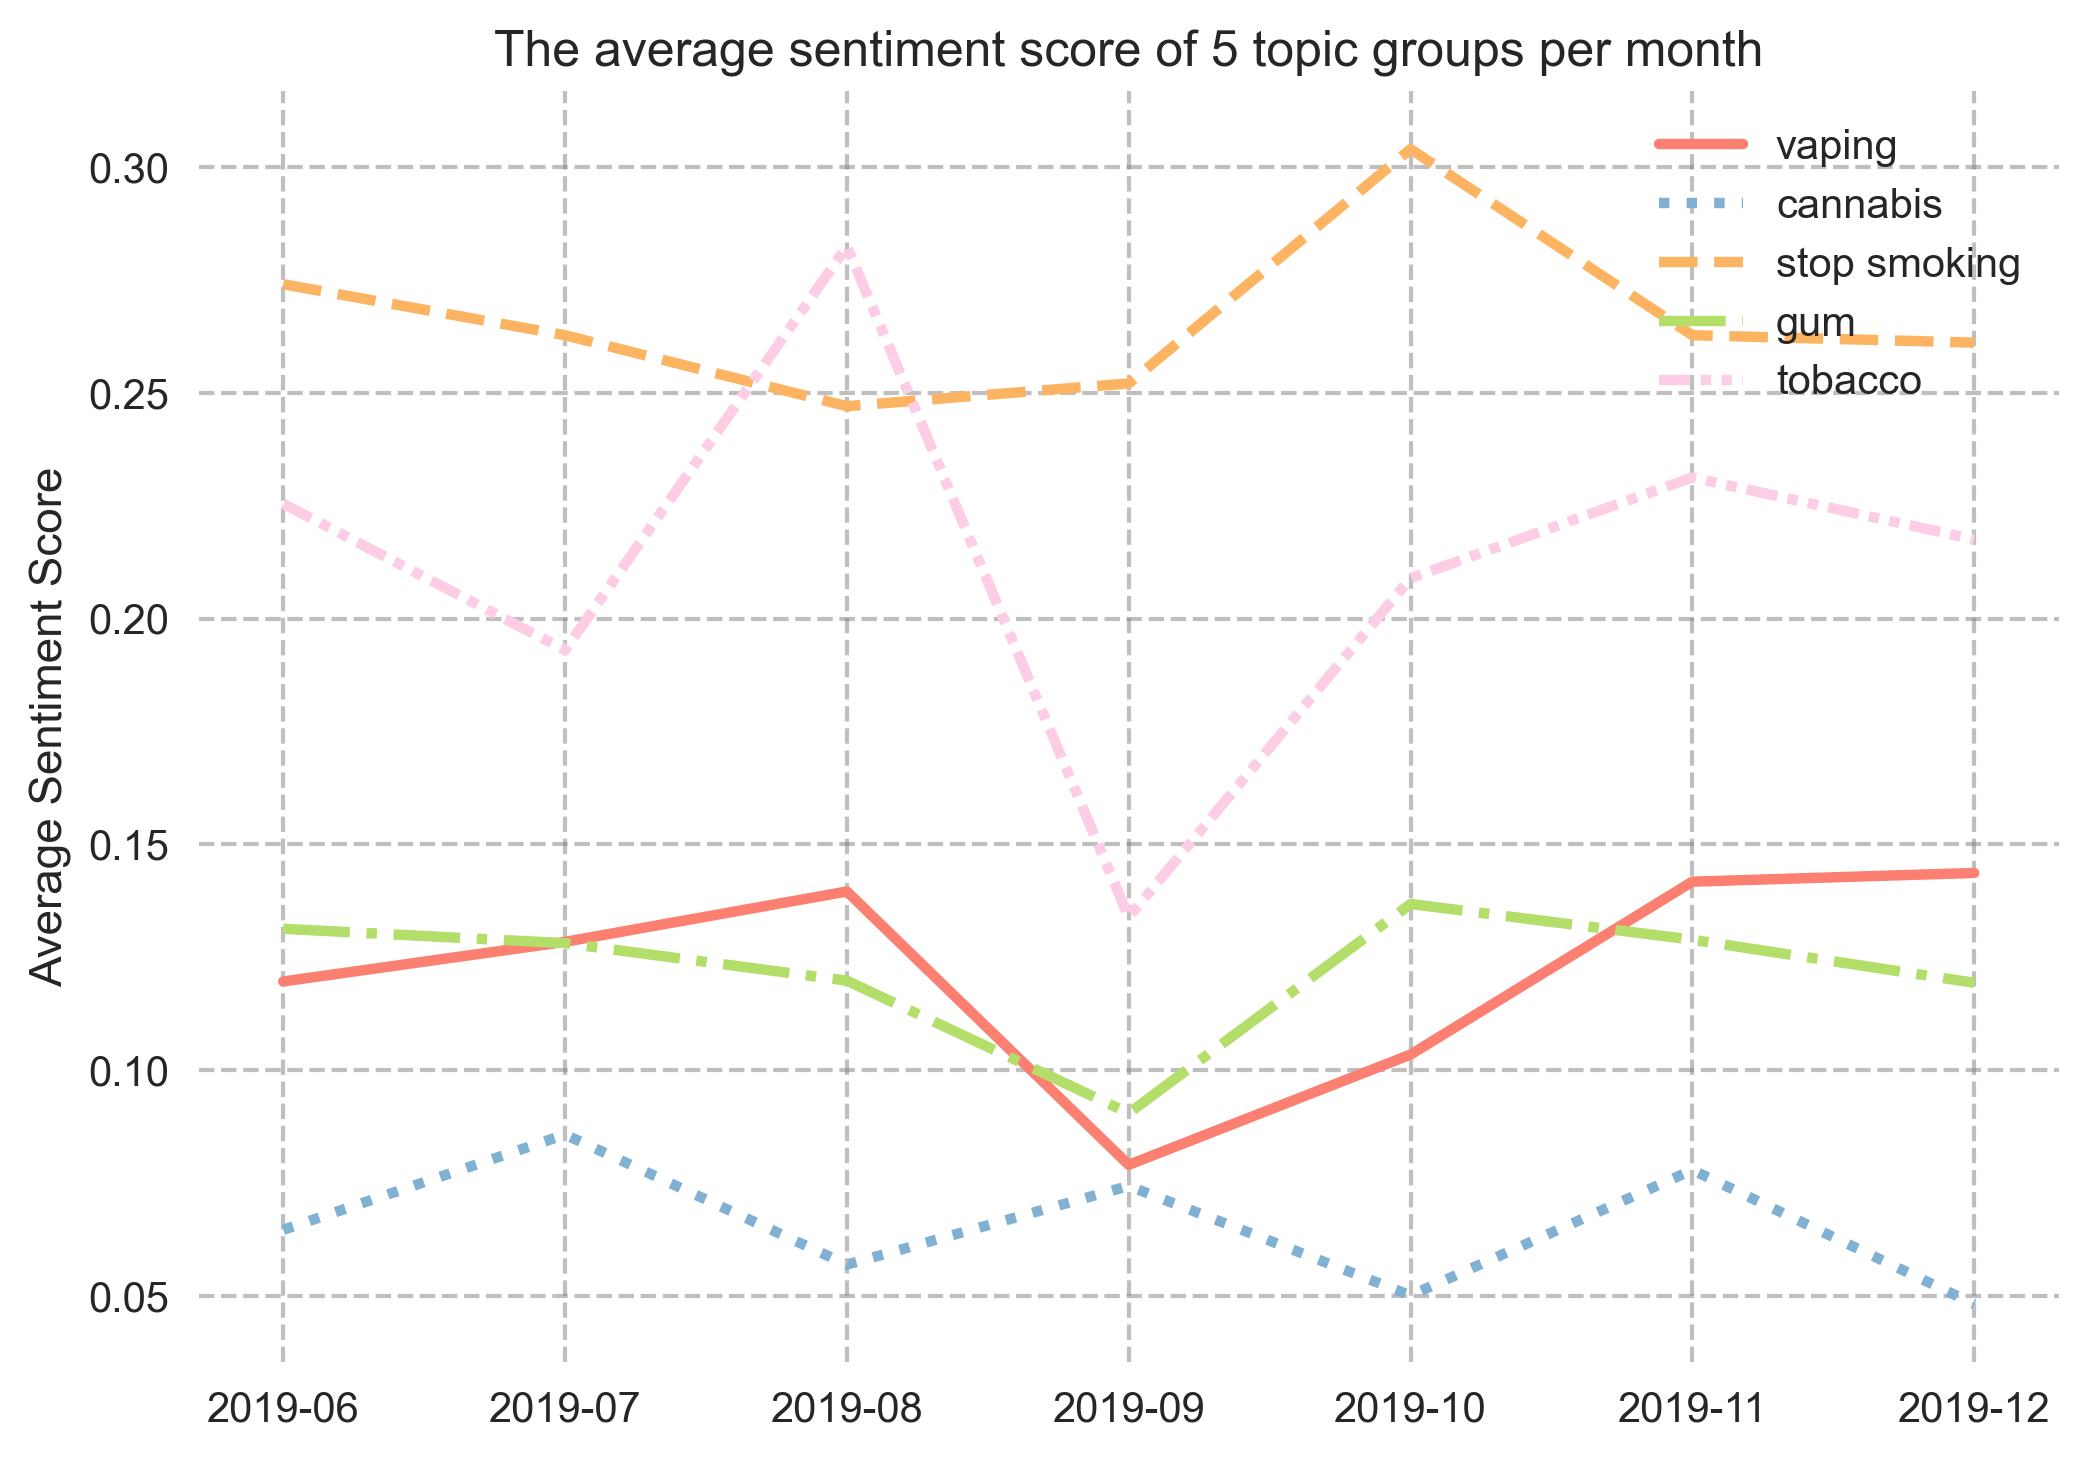

In [126]:
fig, ax = plt.subplots(dpi=300)
plt.plot(["2019-06","2019-07","2019-08","2019-09","2019-10","2019-11","2019-12"],groups_count.get_group("vaping")["controlled_compound"],label="vaping",color=sns.color_palette("Set3")[3],linestyle="solid",linewidth=2.5)
plt.plot(["2019-06","2019-07","2019-08","2019-09","2019-10","2019-11","2019-12"],groups_count.get_group("cannabis")["controlled_compound"],label="cannabis",color=sns.color_palette("Set3")[4],linestyle="dotted",linewidth=2.5)
plt.plot(["2019-06","2019-07","2019-08","2019-09","2019-10","2019-11","2019-12"],groups_count.get_group("stop smoking")["controlled_compound"],label="stop smoking",color=sns.color_palette("Set3")[5],linestyle="dashed",linewidth=2.5)
plt.plot(["2019-06","2019-07","2019-08","2019-09","2019-10","2019-11","2019-12"],groups_count.get_group("gum")["controlled_compound"],label="gum",color=sns.color_palette("Set3")[6],linestyle="dashdot",linewidth=2.5)
plt.plot(["2019-06","2019-07","2019-08","2019-09","2019-10","2019-11","2019-12"],groups_count.get_group("tobacco")["controlled_compound"],label="tobacco",color=sns.color_palette("Set3")[7],linestyle=(0,(3,1,1,1,1,1)),linewidth=2.5)
plt.legend(loc="upper right")
ax.grid(False)
# Remove background color
ax.set_facecolor('none')  # for the axis
fig.set_facecolor('none') # for the figure
ax.grid(True,which='major',axis='y',color='gray',alpha=0.5,linestyle='--')
ax.grid(True,which='major',axis='x',color='gray',alpha=0.5,linestyle='--')
ax.set_ylabel("Average Sentiment Score")
ax.set_title("The average sentiment score of 5 topic groups per month")
fig.savefig('figure3.jpg', format='jpeg', dpi=300, transparent=False)
plt.show()

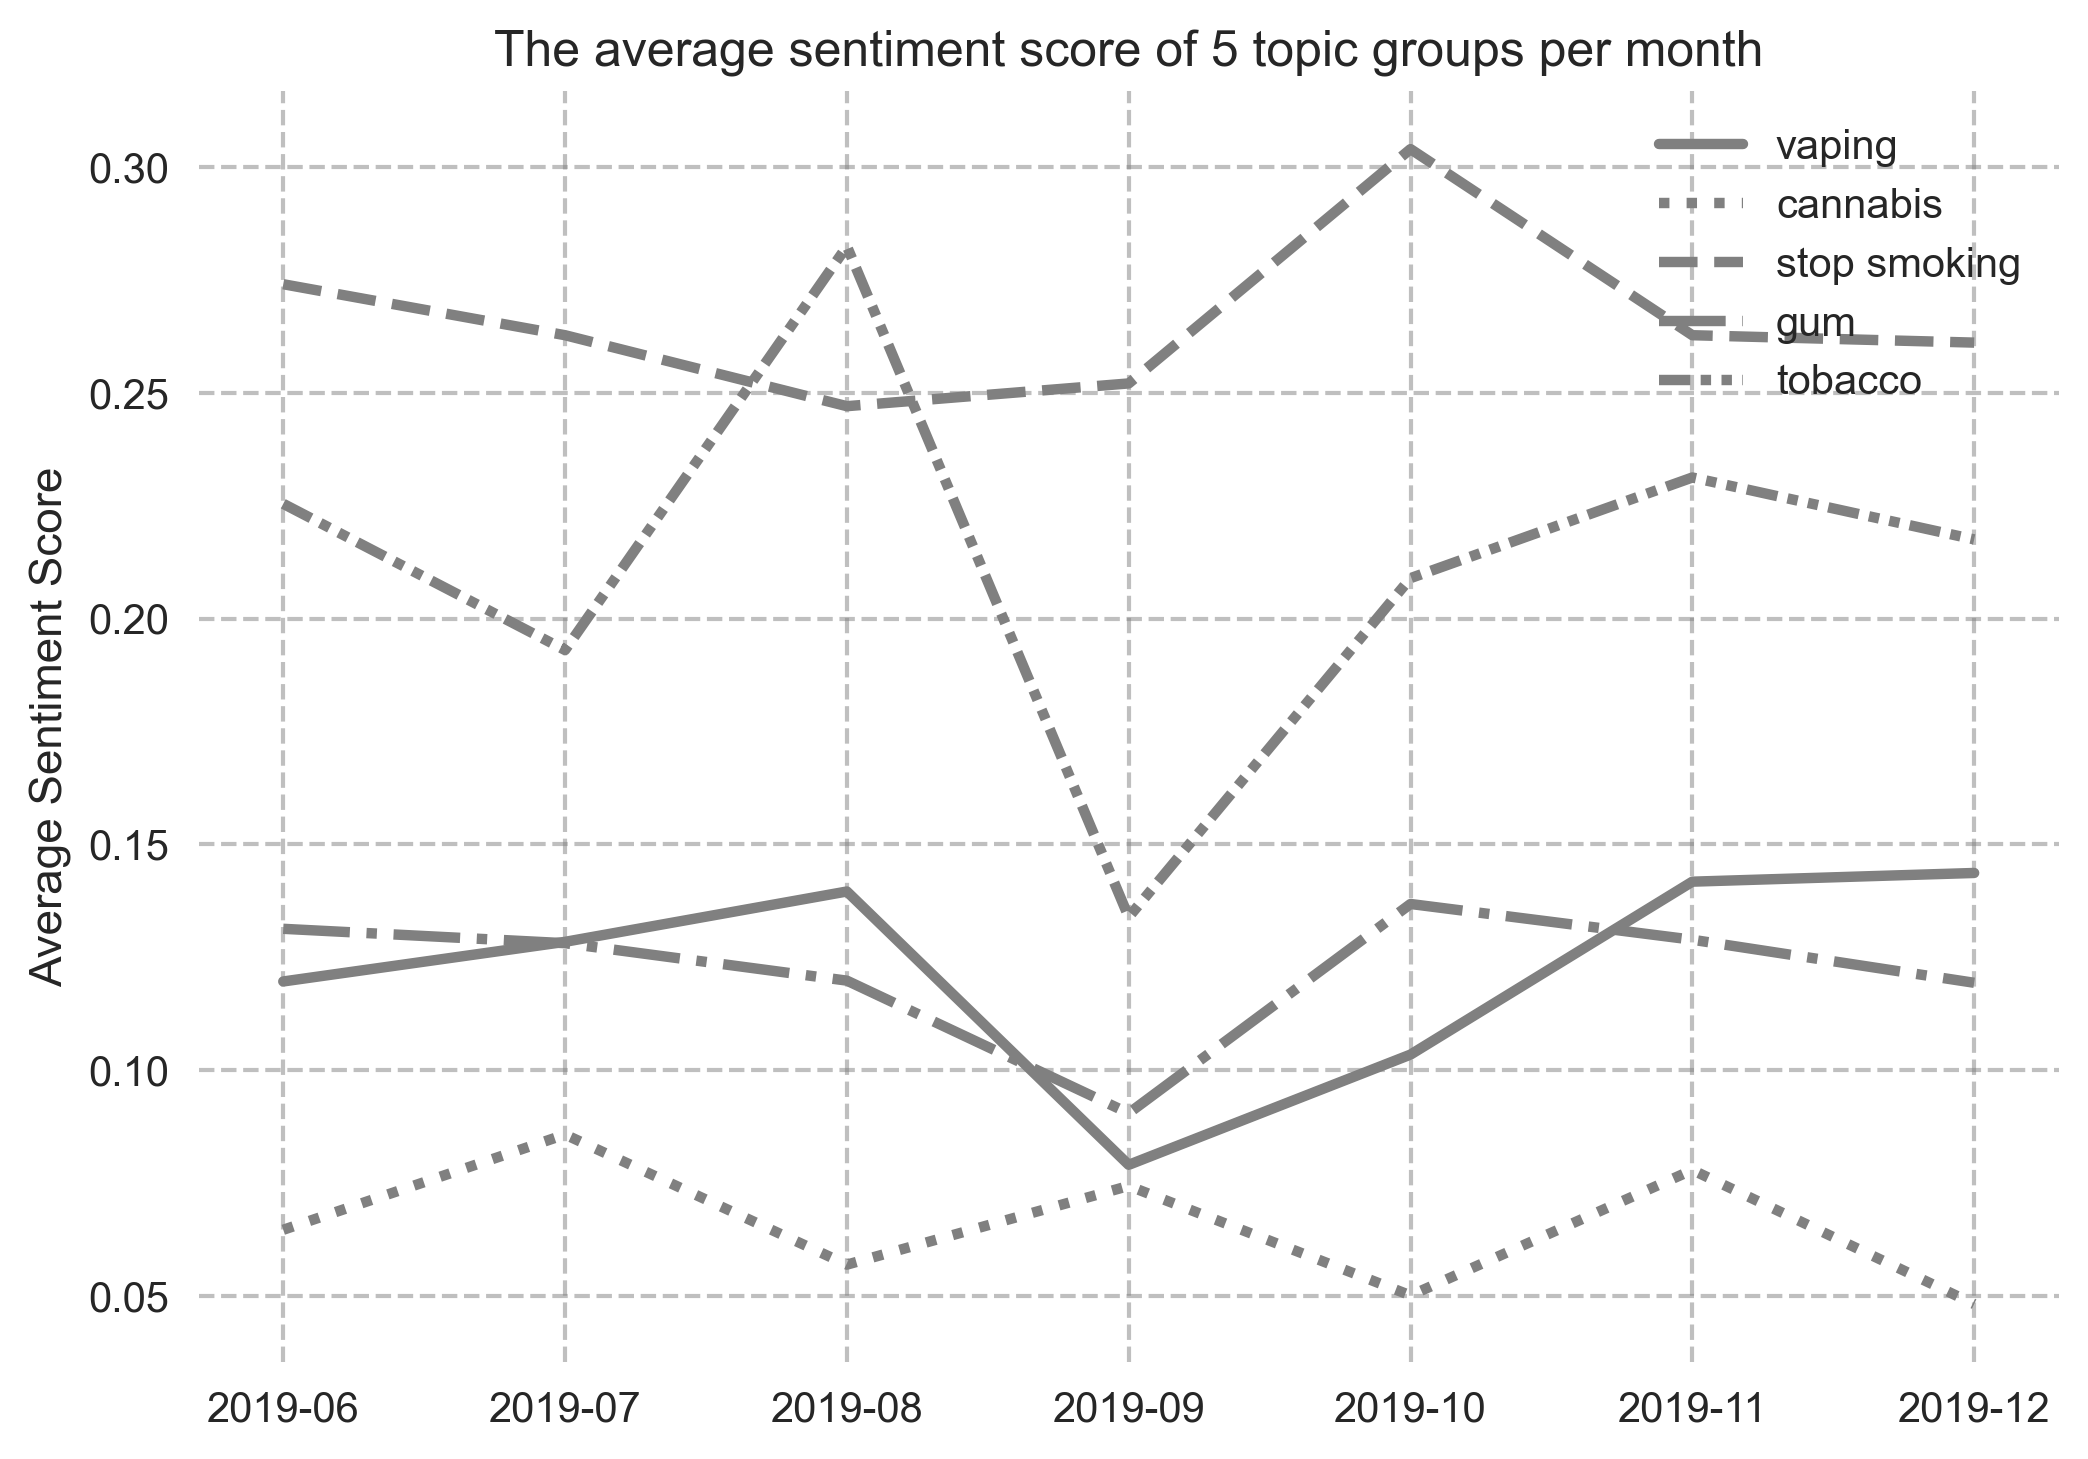

In [127]:
fig, ax = plt.subplots(dpi=300)
plt.plot(["2019-06","2019-07","2019-08","2019-09","2019-10","2019-11","2019-12"],groups_count.get_group("vaping")["controlled_compound"],label="vaping",color='0.5',linestyle="solid",linewidth=2.5)
plt.plot(["2019-06","2019-07","2019-08","2019-09","2019-10","2019-11","2019-12"],groups_count.get_group("cannabis")["controlled_compound"],label="cannabis",color='0.5',linestyle="dotted",linewidth=2.5)
plt.plot(["2019-06","2019-07","2019-08","2019-09","2019-10","2019-11","2019-12"],groups_count.get_group("stop smoking")["controlled_compound"],label="stop smoking",color='0.5',linestyle="dashed",linewidth=2.5)
plt.plot(["2019-06","2019-07","2019-08","2019-09","2019-10","2019-11","2019-12"],groups_count.get_group("gum")["controlled_compound"],label="gum",color='0.5',linestyle="dashdot",linewidth=2.5)
plt.plot(["2019-06","2019-07","2019-08","2019-09","2019-10","2019-11","2019-12"],groups_count.get_group("tobacco")["controlled_compound"],label="tobacco",color='0.5',linestyle=(0,(3,1,1,1,1,1)),linewidth=2.5)
plt.legend(loc="upper right")
ax.grid(False)
# Remove background color
ax.set_facecolor('none')  # for the axis
fig.set_facecolor('none') # for the figure
ax.grid(True,which='major',axis='y',color='gray',alpha=0.5,linestyle='--')
ax.grid(True,which='major',axis='x',color='gray',alpha=0.5,linestyle='--')
ax.set_ylabel("Average Sentiment Score")
ax.set_title("The average sentiment score of 5 topic groups per month")
fig.savefig('Mono figure3.jpg', format='jpeg', dpi=300, transparent=False)
plt.show()

In [73]:
pd.options.display.float_format = '{:.0f}'.format

In [75]:
df["week"] = df["date"].dt.to_period("W")

In [82]:
df["lowercase_content"] = df["content"].apply(lambda x:x.lower())

In [77]:
from lexrank import LexRank
from lexrank.mappings.stopwords import STOPWORDS
from path import Path

lxr = LexRank(list(set(df[df["rearranged_topic"] == "vaping"]["lowercase_content"].to_list())), stopwords=all_stopwords)

In [78]:
summaries = []
for (week,group) in df[df["rearranged_topic"] == "vaping"].groupby("week"):
    print("Current Week: " + str(week))
    summary = lxr.get_summary(list(set(group["lowercase_content"].to_list())), summary_size=5)
    summaries += summary
lxr.get_summary(summaries, summary_size=25)

Current Week: 2018-08-27/2018-09-02
Current Week: 2018-09-03/2018-09-09
Current Week: 2018-09-10/2018-09-16
Current Week: 2018-09-17/2018-09-23
Current Week: 2018-09-24/2018-09-30
Current Week: 2018-10-01/2018-10-07
Current Week: 2018-10-08/2018-10-14
Current Week: 2018-10-15/2018-10-21
Current Week: 2018-10-22/2018-10-28
Current Week: 2018-10-29/2018-11-04
Current Week: 2018-11-05/2018-11-11
Current Week: 2018-11-12/2018-11-18
Current Week: 2018-11-19/2018-11-25
Current Week: 2018-11-26/2018-12-02
Current Week: 2018-12-03/2018-12-09
Current Week: 2018-12-10/2018-12-16
Current Week: 2018-12-17/2018-12-23
Current Week: 2018-12-24/2018-12-30
Current Week: 2018-12-31/2019-01-06
Current Week: 2019-01-07/2019-01-13
Current Week: 2019-01-14/2019-01-20
Current Week: 2019-01-21/2019-01-27
Current Week: 2019-01-28/2019-02-03
Current Week: 2019-02-04/2019-02-10
Current Week: 2019-02-11/2019-02-17
Current Week: 2019-02-18/2019-02-24
Current Week: 2019-02-25/2019-03-03
Current Week: 2019-03-04/201

["been thinking a lot lately about quitting smoking..\n\ni'm thinking maybe i want a new pet to hold me accountable &amp; instead of paying for cigarettes, i want a beta to pay me not to smoke.. 🤔\n\nmaybe a vape slave too..?\n\ndm if you're interested in helping me quit.\n\n• findom •",
 '      i never said vaping was okay. i would never recommend someone vape if they don’t already smoke or vape. no one should start. but for smokers, it’s a great alternative and a good way to quit smoking. i was clearly referring to those that believe nicotine is the issue.',
 'vaping devices have not been proven to help adult smokers quit smoking. however, vaping increases the risk a teen will smoke regular cigarettes later. do we really want the next generation addicted to nicotine? ',
 'guess what y’all? i’ve been nicotine and smoke free for 6 months now. actually over. and i don’t vape. vaping is still smoking. so if you have any inkling of wanting to quit. i’m here. it’s hard but you can do it.',

In [79]:
lxr = LexRank(list(set(df[df["rearranged_topic"] == "tobacco"]["lowercase_content"].to_list())), stopwords=all_stopwords)
summaries = []
for (week,group) in df[df["rearranged_topic"] == "tobacco"].groupby("week"):
    print("Current Week: " + str(week))
    summary = lxr.get_summary(list(set(group["lowercase_content"].to_list())), summary_size=5)
    summaries += summary
lxr.get_summary(summaries, summary_size=25)

Current Week: 2018-08-27/2018-09-02
Current Week: 2018-09-03/2018-09-09
Current Week: 2018-09-10/2018-09-16
Current Week: 2018-09-17/2018-09-23
Current Week: 2018-09-24/2018-09-30
Current Week: 2018-10-01/2018-10-07
Current Week: 2018-10-08/2018-10-14
Current Week: 2018-10-15/2018-10-21
Current Week: 2018-10-22/2018-10-28
Current Week: 2018-10-29/2018-11-04
Current Week: 2018-11-05/2018-11-11
Current Week: 2018-11-12/2018-11-18
Current Week: 2018-11-19/2018-11-25
Current Week: 2018-11-26/2018-12-02
Current Week: 2018-12-03/2018-12-09
Current Week: 2018-12-10/2018-12-16
Current Week: 2018-12-17/2018-12-23
Current Week: 2018-12-24/2018-12-30
Current Week: 2018-12-31/2019-01-06
Current Week: 2019-01-07/2019-01-13
Current Week: 2019-01-14/2019-01-20
Current Week: 2019-01-21/2019-01-27
Current Week: 2019-01-28/2019-02-03
Current Week: 2019-02-04/2019-02-10
Current Week: 2019-02-11/2019-02-17
Current Week: 2019-02-18/2019-02-24
Current Week: 2019-02-25/2019-03-03
Current Week: 2019-03-04/201

['on sale free usa shipping on all 5 packs of cowboys coffee rodeo chew quit chewing\xa0or dipping tobacco nicotine free smokeless smoking alternative to snuff cigarettes  ay\x7f30c6anj mlb nfl nhl nba nascar ',
 'attending the  wales tobacco health network today this morning, which is looking at the question “who can afford to smoke?”\nmany spending more on cigarettes than food and many of those are the poorest in our society. most would like to quit smoking. ',
 'freshly roasted and ground green coffee beans for the perfect cup in a pinch. cowboys rodeo energy chew 5 pack quit chewing tin can non tobacco nicotine free smokeless dip snuff snus  mlb nhl nba nfl nascar 100% safe to eat smoking alternative cigarettes ',
 'on sale now western 5 packs on amazon cowboys cowgirls rodeo bull riding energy chew quit tobacco nicotine free smokeless or smoking alternative cigarettes   mlb nhl nba nfl nascar 100% safe to eat  motivation tuesday thoughts ',
 '\n\nwhat is your take on the tobacco #

In [80]:
lxr = LexRank(list(set(df[df["rearranged_topic"] == "stop smoking"]["lowercase_content"].to_list())), stopwords=all_stopwords)
summaries = []
for (week,group) in df[df["rearranged_topic"] == "stop smoking"].groupby("week"):
    print("Current Week: " + str(week))
    summary = lxr.get_summary(list(set(group["lowercase_content"].to_list())), summary_size=5)
    summaries += summary
lxr.get_summary(summaries, summary_size=25)

Current Week: 2018-08-27/2018-09-02
Current Week: 2018-09-03/2018-09-09
Current Week: 2018-09-10/2018-09-16
Current Week: 2018-09-17/2018-09-23
Current Week: 2018-09-24/2018-09-30
Current Week: 2018-10-01/2018-10-07
Current Week: 2018-10-08/2018-10-14
Current Week: 2018-10-15/2018-10-21
Current Week: 2018-10-22/2018-10-28
Current Week: 2018-10-29/2018-11-04
Current Week: 2018-11-05/2018-11-11
Current Week: 2018-11-12/2018-11-18
Current Week: 2018-11-19/2018-11-25
Current Week: 2018-11-26/2018-12-02
Current Week: 2018-12-03/2018-12-09
Current Week: 2018-12-10/2018-12-16
Current Week: 2018-12-17/2018-12-23
Current Week: 2018-12-24/2018-12-30
Current Week: 2018-12-31/2019-01-06
Current Week: 2019-01-07/2019-01-13
Current Week: 2019-01-14/2019-01-20
Current Week: 2019-01-21/2019-01-27
Current Week: 2019-01-28/2019-02-03
Current Week: 2019-02-04/2019-02-10
Current Week: 2019-02-11/2019-02-17
Current Week: 2019-02-18/2019-02-24
Current Week: 2019-02-25/2019-03-03
Current Week: 2019-03-04/201

[' commissioned jbi &amp;  to assist with revising 2nd edition of ‘supporting smoking cessation: a guide for health professionals’. to develop the guideline we used grade methodology.  read revised guide:   \n  #gradeapproach  #quitsmoking ',
 "healthy heart tip: quit smoking. if you smoke, it's time to quit. at any age quitting improves your health. there are many options to assist you in quitting and your doctor can help you succeed. more info  #quitsmoking #heartmonth #canescares ",
 'maybe your 2018 new year’s resolution was to quit smoking? if it was, congratulations on being smoke free for a year! find out more about discounted life insurance for vapers.  #vape #quitsmoking  ',
 'it’s been 8 months since i picked up smoking again since the last 8 months have been crazy. but i made a promise to myself that i would quit this year and start healthier habits. its been 3 days since my last smoke and i hope to never pick up another ciggy again #quitsmoking 🚬',
 'do you need extra suppo

In [81]:
lxr = LexRank(list(set(df[df["rearranged_topic"] == "cannabis"]["lowercase_content"].to_list())), stopwords=all_stopwords)
summaries = []
for (week,group) in df[df["rearranged_topic"] == "cannabis"].groupby("week"):
    print("Current Week: " + str(week))
    summary = lxr.get_summary(list(set(group["lowercase_content"].to_list())), summary_size=5)
    summaries += summary
lxr.get_summary(summaries, summary_size=25)

Current Week: 2018-08-27/2018-09-02
Current Week: 2018-09-03/2018-09-09
Current Week: 2018-09-10/2018-09-16
Current Week: 2018-09-17/2018-09-23
Current Week: 2018-09-24/2018-09-30
Current Week: 2018-10-01/2018-10-07
Current Week: 2018-10-08/2018-10-14
Current Week: 2018-10-15/2018-10-21
Current Week: 2018-10-22/2018-10-28
Current Week: 2018-10-29/2018-11-04
Current Week: 2018-11-05/2018-11-11
Current Week: 2018-11-12/2018-11-18
Current Week: 2018-11-19/2018-11-25
Current Week: 2018-11-26/2018-12-02
Current Week: 2018-12-03/2018-12-09
Current Week: 2018-12-10/2018-12-16
Current Week: 2018-12-17/2018-12-23
Current Week: 2018-12-24/2018-12-30
Current Week: 2018-12-31/2019-01-06
Current Week: 2019-01-07/2019-01-13
Current Week: 2019-01-14/2019-01-20
Current Week: 2019-01-21/2019-01-27
Current Week: 2019-01-28/2019-02-03
Current Week: 2019-02-04/2019-02-10
Current Week: 2019-02-11/2019-02-17
Current Week: 2019-02-18/2019-02-24
Current Week: 2019-02-25/2019-03-03
Current Week: 2019-03-04/201

['  quit smoking weed',
 'i’m gonna quit smoking weed one day',
 '  my dad used to deny it alllll the time &amp; then when i knew for sure he’d say he quit &amp; what not lol. once my bf &amp; i got together my bf would always give him weed, and they would smoke together and finally like a year or two ago my dad and him were smoking in the garage and my',
 "  quit smoking weed 6 months ago. bought a meth pipe, have an amazing dealer who hooks me up as long i give him top, haven't slept in 4 days. i smoke meth every day, i'm never home. i'm enjoying life. do yourselves a favor. please stop smoking weed. it's cringe as fuck.",
 'now that i don’t smoke weed im back to smoking milds 😩 i just need to quit overall 🤷🏾\u200d♀️',
 "i'm gonna quit smoking weed. and by quitting i just mean paying for it. if you wanna smoke me out, then by all means, bro. let's chief",
 'me: "why can\'t josh gordon just quit smoking weed long enough to make millions and retire, then he can smoke all the weed he wa

In [94]:
lxr = LexRank(list(set(df[df["rearranged_topic"] == "gum"]["lowercase_content"].to_list())), stopwords=all_stopwords)
summaries = []
for (week,group) in df[df["rearranged_topic"] == "gum"].groupby("week"):
    print("Current Week: " + str(week))
    summary = lxr.get_summary(list(set(group["lowercase_content"].to_list())), summary_size=5)
    summaries += summary
lxr.get_summary(summaries, summary_size=25)

Current Week: 2018-08-27/2018-09-02
Current Week: 2018-09-03/2018-09-09
Current Week: 2018-09-10/2018-09-16
Current Week: 2018-09-17/2018-09-23
Current Week: 2018-09-24/2018-09-30
Current Week: 2018-10-01/2018-10-07
Current Week: 2018-10-08/2018-10-14
Current Week: 2018-10-15/2018-10-21
Current Week: 2018-10-22/2018-10-28
Current Week: 2018-10-29/2018-11-04
Current Week: 2018-11-05/2018-11-11
Current Week: 2018-11-12/2018-11-18
Current Week: 2018-11-19/2018-11-25
Current Week: 2018-11-26/2018-12-02
Current Week: 2018-12-03/2018-12-09
Current Week: 2018-12-10/2018-12-16
Current Week: 2018-12-17/2018-12-23
Current Week: 2018-12-24/2018-12-30
Current Week: 2018-12-31/2019-01-06
Current Week: 2019-01-07/2019-01-13
Current Week: 2019-01-14/2019-01-20
Current Week: 2019-01-21/2019-01-27
Current Week: 2019-01-28/2019-02-03
Current Week: 2019-02-04/2019-02-10
Current Week: 2019-02-11/2019-02-17
Current Week: 2019-02-18/2019-02-24
Current Week: 2019-02-25/2019-03-03
Current Week: 2019-03-04/201

[' nicotine is next level addiction, i’ve being trying to quit for years... i don’t smoke cigs but i vape and chew the gum',
 ' i tried chantix, wellbutrin, nic gum\nnothing worked. oh i quit for a couple of weeks then i start smoking again. until i found vaping\ni never smoked another cig again.\ni wanted to be around for my family.\n',
 'e-cigarettes are twice as effective as nicotine patches or gum at helping people quit smoking traditional cigarettes. take a look at this study: ',
 ' jimmy, have you tried the gum? i know for me, in the mornings with my coffee is when i want to smoke the worst. the nicotine  gum, kept my mouth busy and helped with the cravings. i need to quit smoking also.',
 'okay fuck you twitter. i’m sitting here thinking... damn i need to quit smoking and start hitting the gym. and now i’m getting nicorette gum advertisements. this shit a simulation',
 " i quit with the gum fter 30 years of smoking but that was in the 80ies. i kept telling myself i'd start smoki

### Text Summarization

In [84]:
before_evali_tweets = df[df["YYYY-MM"] < "2019-09"]
evali_tweets = df[df["YYYY-MM"] == "2019-09"]
after_evali_tweets = df[df["YYYY-MM"] > "2019-09"]

In [85]:
from lexrank import LexRank
from lexrank.mappings.stopwords import STOPWORDS
from path import Path

lxr = LexRank(list(set(evali_tweets["lowercase_content"].to_list())), stopwords=all_stopwords)

In [86]:
evali_summaries = []
for (week,groups) in evali_tweets.groupby("week"):
    print("Current Week: " + str(week))
    summary = lxr.get_summary(list(set(groups["lowercase_content"].to_list())), summary_size=5)
    evali_summaries += summary

Current Week: 2019-08-26/2019-09-01
Current Week: 2019-09-02/2019-09-08
Current Week: 2019-09-09/2019-09-15
Current Week: 2019-09-16/2019-09-22
Current Week: 2019-09-23/2019-09-29
Current Week: 2019-09-30/2019-10-06


In [87]:
lxr.get_summary(evali_summaries, summary_size=25)

["get ready for #stoptober a day early! with smoke free you'll  have all the best tools you need to quit smoking ❌🚬 scoring a huge 92% on orcha! see our review here:  #smokefree #quitsmoking #mhealth #orcha",
 '  i used to smoke but now vape and chew. i want to quit it all for health reasons. at the same time, i hate thinking about all the money that i flush down the drain on it esp vaping. between the e-juice and replacement coils it is more expensive than smoking.',
 'people: "i don\'t even smoke anymore. i quit! i only vape now."\n\nvaping. is. not. safe.\n\nvaping is not some healthy alternative to smoking cigarettes. i\'ve seen vaping advertised in that manner. that\'s not true.\n\nyou can get sick from #vaping. it is not harmless: ',
 " tbh i can't smoke normal cigarettes. i don't like the overpowering tobacco. if capri went out of business i'd probably quit smoking. everyone gives me shit for them but when they need to bum one they always praise how smooth they are",
 " sells ho

In [95]:
from lexrank import LexRank
from lexrank.mappings.stopwords import STOPWORDS
from path import Path
lxr = LexRank(list(set(before_evali_tweets["lowercase_content"].to_list())), stopwords=all_stopwords)

In [96]:
before_evali_summaries = []
for (week,groups) in before_evali_tweets.groupby("week"):
    print("Current Week: " + str(week))
    summary = lxr.get_summary(list(set(groups["lowercase_content"].to_list())), summary_size=5)
    before_evali_summaries += summary

Current Week: 2018-08-27/2018-09-02
Current Week: 2018-09-03/2018-09-09
Current Week: 2018-09-10/2018-09-16
Current Week: 2018-09-17/2018-09-23
Current Week: 2018-09-24/2018-09-30
Current Week: 2018-10-01/2018-10-07
Current Week: 2018-10-08/2018-10-14
Current Week: 2018-10-15/2018-10-21
Current Week: 2018-10-22/2018-10-28
Current Week: 2018-10-29/2018-11-04
Current Week: 2018-11-05/2018-11-11
Current Week: 2018-11-12/2018-11-18
Current Week: 2018-11-19/2018-11-25
Current Week: 2018-11-26/2018-12-02
Current Week: 2018-12-03/2018-12-09
Current Week: 2018-12-10/2018-12-16
Current Week: 2018-12-17/2018-12-23
Current Week: 2018-12-24/2018-12-30
Current Week: 2018-12-31/2019-01-06
Current Week: 2019-01-07/2019-01-13
Current Week: 2019-01-14/2019-01-20
Current Week: 2019-01-21/2019-01-27
Current Week: 2019-01-28/2019-02-03
Current Week: 2019-02-04/2019-02-10
Current Week: 2019-02-11/2019-02-17
Current Week: 2019-02-18/2019-02-24
Current Week: 2019-02-25/2019-03-03
Current Week: 2019-03-04/201

In [ ]:
lxr.get_summary(before_evali_summaries, summary_size=25)

['do you smoke? do you want to quit? fact: you’re four times more likely to kick the habit if you use a stop smoking product and get advice or support – simply click here for help:    #quitsmoking #antismoking #selfhelp #quickmist #healthyyou #health #fitness',
 'so you want to stop smoking? \n#stopsmoking #quit #non #tips #smoker #smoke #cessation #cigarettes #ecigs #lobby #ecigarettes #electronic #vape #vaper #vaping #drugs #nicotineaddiction ',
 "i quit smoking cold turkey. it's now 5 days minus an hour i'm smoke free. i've been a 2 pack/day for 32 years. imagine how good it is to be a non smoker &amp; use it as my power base for quitting. when craving comes, i acknowledge it's my addiction talking #quitsmoking  #coldturkey",
 'quitting #smoking is really tough. #tooth decay, gum disease and oral #cancer are all possibilities when you smoke or use #tobacco, so work with your #dentist  and doctor to get the support you need to help quit smoking. ',
 'vaping helped  father quit smokin

In [91]:
from lexrank import LexRank
from lexrank.mappings.stopwords import STOPWORDS
from path import Path
lxr = LexRank(list(set(after_evali_tweets["lowercase_content"].to_list())), stopwords=all_stopwords)

In [92]:
after_evali_summaries = []
for (week,groups) in after_evali_tweets.groupby("week"):
    print("Current Week: " + str(week))
    summary = lxr.get_summary(list(set(groups["lowercase_content"].to_list())), summary_size=5)
    after_evali_summaries += summary

Current Week: 2019-09-30/2019-10-06
Current Week: 2019-10-07/2019-10-13
Current Week: 2019-10-14/2019-10-20
Current Week: 2019-10-21/2019-10-27
Current Week: 2019-10-28/2019-11-03
Current Week: 2019-11-04/2019-11-10
Current Week: 2019-11-11/2019-11-17
Current Week: 2019-11-18/2019-11-24
Current Week: 2019-11-25/2019-12-01
Current Week: 2019-12-02/2019-12-08
Current Week: 2019-12-09/2019-12-15
Current Week: 2019-12-16/2019-12-22
Current Week: 2019-12-23/2019-12-29
Current Week: 2019-12-30/2020-01-05
Current Week: 2020-01-06/2020-01-12
Current Week: 2020-01-13/2020-01-19
Current Week: 2020-01-20/2020-01-26
Current Week: 2020-01-27/2020-02-02


In [93]:
lxr.get_summary(after_evali_summaries, summary_size=25)

['  i quit smoking cigarettes using flavored vapor products. 5 years smoke free after smoking cigarettes for 15 years. my lungs feel amazing and i have my life back thanks to vaping.',
 ' breaking the habit part is the hardest but most successful way to quit.. also i have mints and gum packed in my car because i always want to smoke while driving. 7 years smoke free after 20yrs of smoking',
 'do you or did you #smoke after most meals? \n\nfor many who just quit #smoking, the end of a meal can be a trigger. try brushing your teeth after a meal or chewing gum, or doing something to keep your mind and hands busy. 😁 ',
 " funny how nicotine patches and gum didn't work for me. chantix made me want to commit suicide. only vaping flavored ejuice helped me quit smoking. 3 years smoke free!",
 ' i quit a year ago today!! i didn’t smoke for nearly as long but i was smoking for about 8 years. i did it cold turkey because i didn’t want to pick up a new habit in gum or vaping and the first 3 weeks 